# Workflow to Validate OPERA DISP-S1 Secular Displacement Requirement

- **Original code authored by:** David Bekaert, Heresh Fattahi, Eric Fielding, and Zhang Yunjun with 
Extensive modifications by Adrian Borsa and Amy Whetter and other NISAR team members 2022

- **Updated for OPERA requirements by Simran Sangha, Marin Govorcin, and Al Handwerger**

- **Updated by OPERA DISP-S1 CalVal team** July, 2024


<div class="alert alert-warning">
Both the initial setup (<b>Prep A</b> section) and download of the data (<b>Prep B</b> section) should be run at the start of the notebook. And all subsequent sections NEED to be run in order.
</div>



In [1]:
# Parameters for papermill

### Choose a site from the 'sites' dictionary found 2 cells down
site = 'F33039'
work_dir = './'
mintpy_dir = 'mintpy_output'    # location of mintpy files
output_dir = 'results'          # location to store output figures and text files
vmin = -20  # vmin/vmax for plotting
vmax = 20

calval_sites_csv = 'validation_data/DISP-S1_CalVal_sites.csv'

# Mask file used for validation
maskFile = 'mask_temporalCoherence.h5' # maskSpatialCoh.h5, temporalCoherence.h5, inputs/combined_msk.h5

# Define spatial coherence threshold (necessary to reject poor quality, long temporal baseline pairs)
coherenceBased_parm = 'yes'
minCoherence_parm = '0.6'
minTempCoherence_parm = '0.6'

#Set GNSS Parameters
gps_completeness_threshold = 0.9    #0.9  #percent of data timespan with valid GNSS epochs
gps_residual_stdev_threshold = 10.  #0.03  #0.03  #max threshold standard deviation of residuals to linear GNSS fit

#variability score threshold
apply_nonlinear_mask = True
thr_var_score = 0.3      # variability score threshold

In [2]:
# load packages
import os
from datetime import datetime as dt
from pathlib import Path
import math

import numpy as np
import pandas as pd
from scipy import signal

import matplotlib
import matplotlib.colors
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'font.size': 12})

import rioxarray
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Transformer, CRS
import rasterio
from affine import Affine

from mintpy.objects import gnss, timeseries
from mintpy.utils import ptime, readfile, utils as ut, utils0 as ut0
from mintpy.cli import view, reference_point, generate_mask

from solid_utils.sampling import load_geo_utm, samp_pair, euclidean_distance, profile_samples_utm
from solid_utils.plotting import display_validation, display_validation_table

import imgkit   # pip install imgkit / conda install -c conda-forge wkhtmltopdf  # exporting pandas table to png

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Define CalVal Site 

In [3]:
### Define list of requirements
## Static for OPERA Cal/Val requirements, do not touch!

# Define secular requirements
secular_gnss_rqmt = 3  # mm/yr for 3 years of data over length scales of 0.1-50 km
gnss_dist_rqmt = [0.1, 50.0]  # km
secular_disp_s1_rqmt = 3  # mm/yr
disp_s1_dist_rqmt = [0.1, 50.0]  # km

# Define temporal sampling requirement
disp_s1_sampling = 12 # days
disp_s1_sampling_percentage = 80 # percentage of acquitions at 12 day sampling (disp_s1_sampling) or better
disp_s1_timespan_requirement = 4 # years

# specify number of DISP-S1 pixels to average for comparison with GNSS
pixel_radius = 5

# specify GNSS source for validation
gnss_source = 'UNR'
print(f'Searching for all GNSS stations from source: {gnss_source}')
print(f'May use any of the following supported sources: {gnss.GNSS_SOURCES}')
GNSS = gnss.get_gnss_class(gnss_source)

Searching for all GNSS stations from source: UNR
May use any of the following supported sources: ['UNR', 'ESESES', 'JPL-SIDESHOW', 'GENERIC']


In [4]:
################# Set Directories ##########################################
print('\nCurrent directory:', os.getcwd())

if 'work_dir' not in locals():
    work_dir = Path.cwd()

work_dir = os.path.abspath(work_dir)    # absolute path       
print("Work directory:", work_dir)
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)  # Change to Workdir   

mintpy_dir = f'{work_dir}/{mintpy_dir}'     # absolute path of mintpy directory 
if not os.path.isdir(mintpy_dir):
    raise FileNotFoundError(f"The folder '{mintpy_dir}' does not exist.")
print("   MintPy  dir:", mintpy_dir)

output_dir = f'{work_dir}/{output_dir}'     # absolute path of output directory
os.makedirs(output_dir, exist_ok=True)
print("   output  dir:", output_dir)

############################################################################
### List of OPERA DISP-S1 Cal/Val Sites for secular requirements:
if os.path.exists(calval_sites_csv):
    sites_df = pd.read_csv(calval_sites_csv) 
else:
    raise FileNotFoundError(f"The file {calval_sites_csv} does not exist.")  

display(sites_df)

secular_available_sites = sites_df['site'].values


Current directory: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F33039
Work directory: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F33039
   MintPy  dir: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F33039/mintpy_output
   output  dir: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F33039/results


site     calval_location   reference_lalo gps_ref_site_name priority
0  F08882             Houston   29.692 -95.635              ALEF     high
1  F11115  Central California  37.104 -121.651              P217     high
2  F11116  Central California    35.9 -120.473              LAND     high
3  F12640             Florida   29.056 -81.263              DLND     high
4  F18903            Rosamond  35.039 -118.006              P579     high
5  F28486            Oklahoma   34.133 -99.283              TXVE     high
6  F33039              Hawaii  19.450 -155.525              ELEP     high
7  F33065       Unimak Island  54.831 -163.781              AV38     high
8  F36542  Central California  36.516 -120.853              P286     high
9  F42779              Alaska  61.550 -149.327              STEM     high

## Table of Contents:
<a id='secular_TOC'></a>

<hr/>

[**Prep A. Environment Setup**](#secular_prep_a)

[**Prep B. Data Staging**](#secular_prep_b)

[**1. Generate Interferogram Stack**](#secular_gen_ifg)
- [1.1.  Generate interferograms using dolphin](#secular_crop_ifg)

[**2. Generation of Time Series from Interferograms**](#secular_gen_ts)
- [2.1. Set Up MintPy Configuration file](#secular_setup_config)
- [2.2. Load Data into MintPy](#secular_load_data)
- [2.3. Generate Quality Control Mask](#secular_generate_mask)

[**3. Optional Corrections**](#secular_opt_correction)
- [3.1. Topographic Residual Correction ](#secular_topo_corr) 

[**4. Estimate disp_s1 and GNSS Velocities**](#secular_decomp_ts)
- [4.1. Estimate disp_s1 LOS Velocities](#secular_disp_s1_vel1)
- [4.2. Find Collocated GNSS Stations](#secular_co_gps)  
- [4.3. Get GNSS Position Time Series](#secular_gps_ts) 
- [4.4. Make GNSS LOS Velocities](#secular_gps_los)
- [4.5. Re-Reference GNSS and disp_s1 Velocities](#secular_gps_disp_s1)

[**5. NISAR Validation Approach 1: GNSS-disp_s1 Direct Comparison**](#secular_nisar_validation)
- [5.1. Make Velocity Residuals at GNSS Locations](#secular_make_vel)
- [5.2. Make Double-differenced Velocity Residuals](#secular_make_velres)
- [5.3. Secular Requirement Validation: Method 1](#secular_valid_method1)

[**6. NISAR Validation Approach 2: InSAR-only Structure Function**](#secular_nisar_validation2)
- [6.1. Read Array and Mask Pixels with no Data](#secular_array_mask)
- [6.2. Randomly Sample Pixels and Pair Them Up with Option to Remove Trend](#secular_remove_trend)
- [6.3. Amplitude vs. Distance of Relative Measurements (pair differences)](#secular_M2ampvsdist2)
- [6.4. Bin Sample Pairs by Distance Bin and Calculate Statistics](#secular_M2RelMeasTable)

[**Appendix: Supplementary Comparisons and Plots**](#secular_appendix1)
- [A.1. Compare Raw Velocities](#secular_compare_raw)
- [A.2. Plot Velocity Residuals](#secular_plot_vel)
- [A.3. Plot Double-differenced Residuals](#secular_plot_velres)
- [A.4. GPS Position Plot](#secular_appendix_gps)

<hr/>

<a id='secular_prep_a'></a>
## Prep A. Environment Setup
Setup your environment for processing data

In [5]:
#Set Global Plot Parameters
vel_file = os.path.join(mintpy_dir, 'velocity.h5')
disp_s1_ts_file = os.path.join(mintpy_dir, 'timeseries.h5')

if os.path.exists(vel_file) and os.path.exists(disp_s1_ts_file):
    print(f'{vel_file} and {disp_s1_ts_file} exist and we can continue this validation.')
else:
    raise FileNotFoundError(f"The {vel_file} and/or {disp_s1_ts_file} do not exist and are required for this validation.")

msk_file = os.path.join(mintpy_dir, maskFile)  # maskTempCoh.h5 maskSpatialCoh.h5 maskConnComp.h5 waterMask.h5

if site not in secular_available_sites:
    msg = '\nSelected site not available! Please select one of the following sites:: \n{}'.format(secular_available_sites)
    raise Exception(msg)
else:
    print('\nSelected site: {}'.format(site))
    display(sites_df[sites_df['site'] == site])

os.chdir(mintpy_dir)  # move to MintPy directory 

/lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F33039/mintpy_output/velocity.h5 and /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F33039/mintpy_output/timeseries.h5 exist and we can continue this validation.

Selected site: F33039


site calval_location   reference_lalo gps_ref_site_name priority
6  F33039          Hawaii  19.450 -155.525              ELEP     high

In [6]:
# reading area of DISP-S1
disp_s1_metadata = readfile.read_attribute(vel_file)

assert 'UTM_ZONE' in disp_s1_metadata.keys()  # make sure data in UTM zone

DISP_region = list(ut.four_corners(disp_s1_metadata))

geo_S, geo_W = ut0.utm2latlon(disp_s1_metadata, DISP_region[2], DISP_region[0])
geo_N, geo_E = ut0.utm2latlon(disp_s1_metadata, DISP_region[3], DISP_region[1])
DISP_region_geo = (geo_S, geo_N, geo_W, geo_E)

print(f'region of DISP-S1 (UTM): {DISP_region}, Zone: {disp_s1_metadata["UTM_ZONE"]}')
print('region of DISP-S1 (lat/lon): ', DISP_region_geo)

region of DISP-S1 (UTM): [2090790.0, 2326890.0, 72930.0, 358680.0], Zone: 05N
region of DISP-S1 (lat/lon):  (18.865105209397647, 21.037409220934865, -157.05172935959655, -154.36002063342457)


<a id='secular_gen_ts'></a>
# 2. Generation of Time Series from Interferograms

InSAR time series (i.e., the unfiltered displacement of each pixel vs. time) are estimated from a processed InSAR stack from Section 3.1 (either ascending or descending) using a variant of the small baseline subset (SBAS) approach and then parameterized using the approach described in Section 4. This step uses tools available in the MintPy software package (Yunjun et al. (2019)), which provides both SBAS time series and model-based time series parameterization. Recent results on InSAR closure phase and “fading signal” recommend the of use all available interferograms to avoid systematic bias (_Ansari et al._, 2020; _Zheng Y.J. et al._, 2022). As we expect high-quality orbital control for NISAR, we anticipate that the interferogram stack will typically include all nearest-neighbor (i.e., ~12-day pairs) and skip-1 interferograms, which will be the minimum inputs into the SBAS generation step.

<a id='secular_load_data'></a>
## 2.1. Load Data into MintPy

The output of this step is an "inputs" directory in 'calval_directory/calval_location/MintPy/" containing two HDF5 files:
- ifgramStack.h5: This file contains 6 dataset cubes (e.g. unwrapped phase, coherence, connected components etc.) and multiple metadata
- geometryGeo.h5: This file contains geometrical datasets (e.g., incidence/azimuth angle, masks, etc.)

<a id='secular_generate_mask'></a>
## 2.2. Generate Quality Control Mask

Mask files can be can be used to mask pixels in the time-series processing. Below we generate a mask file based on the connected components, which is a metric for unwrapping quality.

run view.py in MintPy version 1.6.0.post11, date 2024-06-25
input file is mask file: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F33039/mintpy_output/mask_temporalCoherence.h5 in bool format
file size in y/x: (7870, 9525)
input dataset: "['mask']"
num of datasets in file mask_temporalCoherence.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['mask']
data   coverage in y/x: (0, 0, 9525, 7870)
subset coverage in y/x: (0, 0, 9525, 7870)
data   coverage in lat/lon: (72930.0, 2326890.0, 358680.0, 2090790.0)
subset coverage in lat/lon: (72930.0, 2326890.0, 358680.0, 2090790.0)
------------------------------------------------------------------------
colormap: jet
figure title: mask_temporalCoherence
figure size : [9.1, 6.0]
reading data ...
data has uniform and limited number (2 <= 20) of unique values --> discretize colormap
data    range: [False, True] 1
display range: [-0.5, 1.5] 1
display data in transparency: 1.0
plot in geo-coordinate
plotting data as image

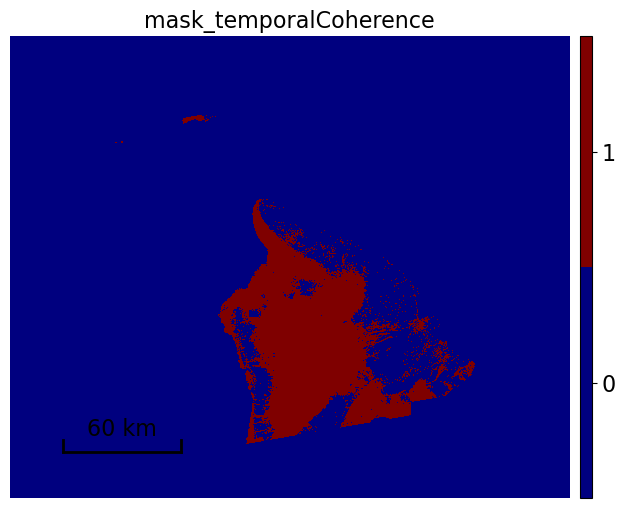

In [7]:
if not os.path.exists(msk_file):

    if (os.path.basename(msk_file) == 'maskSpatialCoh.h5'):

        if not os.path.exists('avgSpatialCoh.h5'):
            raise FileNotFoundError("cannot find avgSpatialCoh.h5")
        
        view.main(f'avgSpatialCoh.h5 --noaxis --noverbose'.split()) # average spatial coherence

        iargs = [f'avgSpatialCoh.h5', '-m', minCoherence_parm, '-o', maskFile]
        generate_mask.main(iargs)
    elif (os.path.basename(msk_file) == 'mask_temporalCoherence.h5'):

        if not os.path.exists('inputs/temporalCoherence.h5'):
            raise FileNotFoundError("cannot find inputs/temporalCoherence.h5")
        
        view.main(f'inputs/temporalCoherence.h5 --noaxis --noverbose'.split()) # average spatial coherence

        iargs = [f'inputs/temporalCoherence.h5', '-m', minTempCoherence_parm, '-o', maskFile]
        generate_mask.main(iargs)
    else:
        raise FileNotFoundError(f"The maskfile {msk_file} not found.")

# view mask
view.main([msk_file, 'mask', '--noaxis'])

<a id='secular_common_latlon'></a>
## 2.3. Reference Interferograms To Common Lat/Lon

In [8]:
lat = sites_df[sites_df['site'] == site]['reference_lalo'].values[0].split()[0]
lon = sites_df[sites_df['site'] == site]['reference_lalo'].values[0].split()[1]

iargs = [disp_s1_ts_file, '-l', lat, '-L', lon]
reference_point.main(iargs)

--------------------------------------------------
input reference point in lat/lon: (19.45, -155.525)
input reference point in y/x: (5810, 5398)
--------------------------------------------------
calculating the temporal average of timeseries file: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F33039/mintpy_output/timeseries.h5
reading timeseries data from file: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F33039/mintpy_output/timeseries.h5 ...
updating dataset values without re-writing to a new file
update metadata


In [9]:
# Get date list
date_list = timeseries(disp_s1_ts_file).get_date_list()
num_date = len(date_list)
date0, date1 = date_list[0], date_list[-1]
disp_s1_dates = ptime.date_list2vector(date_list)[0]

# Check temporal sampling
disp_s1_sampling_arr = []
for i in range(len(disp_s1_dates)-1):
    diff = (disp_s1_dates[i+1] - disp_s1_dates[i]).days
    disp_s1_sampling_arr.append(diff)

count = 0
for i in disp_s1_sampling_arr:
    if i <= disp_s1_sampling:
        count += 1

percentage = (count / len(disp_s1_sampling_arr)) * 100
timespan_of_disp_s1=(disp_s1_dates[len(disp_s1_dates)-1]-disp_s1_dates[0]).days /365.25

# Overall pass/fail criterion
if percentage >= disp_s1_sampling_percentage:
    print(f'This velocity dataset ({percentage}%) passes the temporal sampling requirement ({disp_s1_sampling_percentage}%)')
else:
    print(f'This velocity dataset ({percentage}%) does NOT pass the temporal sampling requirement ({disp_s1_sampling_percentage}%)')

if timespan_of_disp_s1 >= disp_s1_timespan_requirement:
    print(f'This velocity dataset ({timespan_of_disp_s1} years) passes the timespan requirement ({disp_s1_timespan_requirement} years)')
else:
    print(f'This velocity dataset ({timespan_of_disp_s1} years) does NOT pass the timespan requirement ({disp_s1_timespan_requirement } years)')

This velocity dataset (98.81889763779527%) passes the temporal sampling requirement (80%)
This velocity dataset (4.7967145790554415 years) passes the timespan requirement (4 years)


<a id='secular_opt_correction'></a>
# 3. Optional Corrections

`TODO`
Applying optional corrections related with tropospheric (dtropospheric_delay.h5) /ionospheric delay (ionospheric_delay.h5), solid earth tide (dsolid_earth_tide.h5), and plate motion (dplate_motion.h5)

<a id='secular_decomp_ts'></a>
# 4. Estimate InSAR and GNSS Velocities
The approach that will be used for the generation of NISAR L3 products for Requirements 660 and 663 allows for an explicit inclusion of key basis functions (e.g., Heaviside functions, secular rate, etc.) in the InSAR inversion. Modifications to this algorithm may be identified and implemented in response to NISAR Phase C activities. 

<a id='secular_insar_vel1'></a>
## 4.1. Estimate InSAR LOS Velocities

Given a time series of InSAR LOS displacements, the observations for a given pixel, $U(t)$, can be parameterized as:

$$U(t) = a \;+\; vt \;+\; c_1 cos (\omega_1t - \phi_{1,}) \;+\; c_2 cos (\omega_2t - \phi_2) \;+\; \sum_{j=1}^{N_{eq}} \left( h_j+f_j F_j (t-t_j) \right)H(t - t_j) \;+\; \frac{B_\perp (t)}{R sin \theta}\delta z \;+\; residual$$ 

which includes a constant offset $(a)$, velocity $(v)$, and amplitudes $(c_j)$ and phases $(\phi_j)$ of annual $(\omega_1)$ and semiannual $(\omega_2)$ sinusoidal terms.  Where needed we can include additional complexity, such as coseismic and postseismic processes parameterized by Heaviside (step) functions $H$ and postseismic functions $F$ (the latter typically exponential and/or logarithmic).   $B_\perp(t)$, $R$, $\theta$, and $\delta z$ are, respectively, the perpendicular component of the interferometric baseline relative to the first date, slant range distance, incidence angle and topography error correction for the given pixel. 

Thus, given either an ensemble of interferograms or the output of SBAS (displacement vs. time), we can write the LSQ problem as 

$$ \textbf{G}\textbf{m} = \textbf{d}$$

where $\textbf{G}$ is the design matrix (constructed out of the different functional terms in Equation 2 evaluated either at the SAR image dates for SBAS output, or between the dates spanned by each pair for interferograms), $\textbf{m}$ is the vector of model parameters (the coefficients in Equation 2) and $\textbf{d}$ is the vector of observations.  For GPS time series, $\textbf{G}, \textbf{d}, \textbf{m}$ are constructed using values evaluated at single epochs corresponding to the GPS solution times, as for SBAS InSAR input. 

With this formulation, we can obtain InSAR velocity estimates and their formal uncertainties (including in areas where the expected answer is zero). 

The default InSAR velocity fit in MintPy is to estimate a mean linear velocity $(v)$ in in the equation, which we do below. 

In [10]:
# load velocity file
disp_s1_velocities,_ = readfile.read(vel_file, datasetName = 'velocity')  # read velocity file
disp_s1_velocities = disp_s1_velocities * 1000.  # convert velocities from m to mm/yr

# set masked pixels to NaN
msk,_ = readfile.read(msk_file)
disp_s1_velocities[msk == 0] = np.nan
disp_s1_velocities[disp_s1_velocities == 0] = np.nan

Now we plot the mean linear velocity fit. The MintPy `view` module automatically reads the temporal coherence mask `maskTempCoh.h5` and applies that to mask out pixels with unreliable velocities (white).

run view.py in MintPy version 1.6.0.post11, date 2024-06-25
input file is velocity file: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F33039/mintpy_output/velocity.h5 in float32 format
file size in y/x: (7870, 9525)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 9525, 7870)
subset coverage in y/x: (0, 0, 9525, 7870)
data   coverage in lat/lon: (72930.0, 2326890.0, 358680.0, 2090790.0)
subset coverage in lat/lon: (72930.0, 2326890.0, 358680.0, 2090790.0)
------------------------------------------------------------------------
colormap: RdBu_r
figure title: LOS_Velocity
read mask from file: mask_temporalCoherence.h5
reading data ...
masking data
data    range: [-180.9273, 36.913864] mm/year
display range: [-20.0, 20.0] mm/year
display data in transparency: 1.0
plot in geo-coordinate
plotting data as image via ma

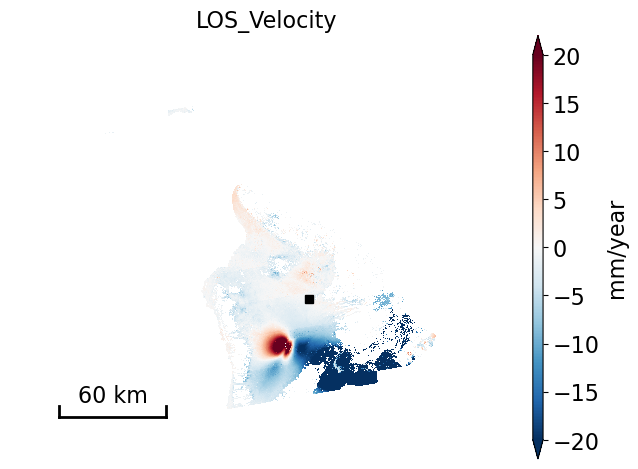

In [11]:
scp_args = f'{vel_file} velocity -v {vmin} {vmax} --colormap RdBu_r --noaxis --figsize 18 5.5 --figtitle LOS_Velocity --unit mm/yr -m ' + msk_file
view.main(scp_args.split())

### Applying nonlinear-displacement mask

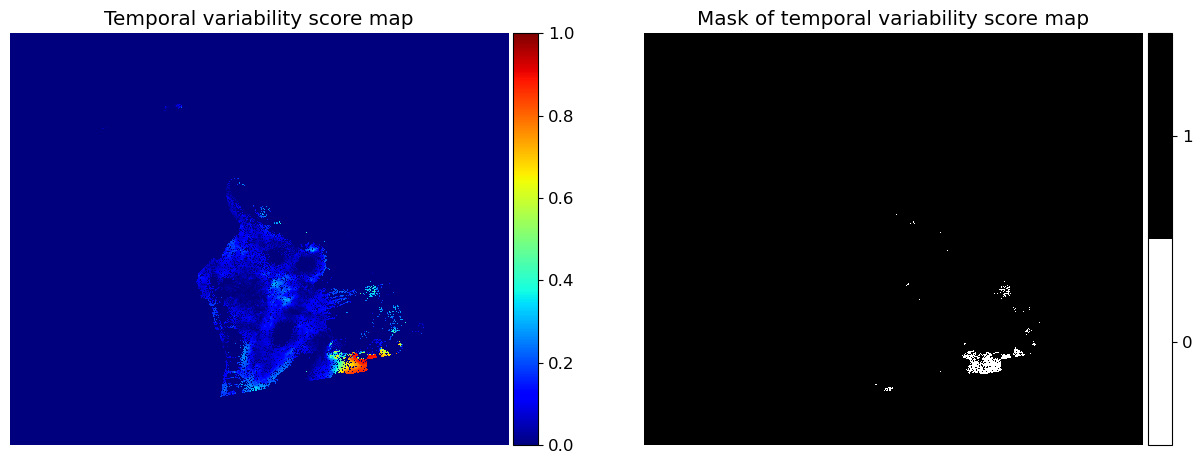

In [12]:
score_map_file = 'nonDispScore.h5'
score_map_file = os.path.join(mintpy_dir, score_map_file)

if apply_nonlinear_mask:

    variability_scores = readfile.read(score_map_file)[0]
    mask_var_score = variability_scores < thr_var_score     # selecting pixels with small temporal variability score
    disp_s1_velocities[mask_var_score == 0] = np.nan    # added for nonlinear def masking

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

    im1 = ax1.imshow(variability_scores, cmap='jet', vmin=0, vmax=1, interpolation='none')
    ax1.axis('off')
    ax1.set_title('Temporal variability score map')

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax)

    cmap_bw = matplotlib.colors.ListedColormap(['white', 'black'])
    im2 = ax2.imshow(mask_var_score, cmap_bw, interpolation='none')
    ax2.axis('off')
    ax2.set_title('Mask of temporal variability score map')

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im2, cax=cax)
    cbar.set_ticks([0.25, 0.75])    # Set tick locations to the center of each color range
    cbar.set_ticklabels(['0', '1'])     # Set tick labels

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cax.axis('off')

<div class="alert alert-info">
<b>Note :</b> 
Negative values indicates that target is moving away from the radar (i.e., Subsidence in case of vertical deformation).
Positive values indicates that target is moving towards the radar (i.e., uplift in case of vertical deformation). 
</div>

<a id='secular_co_gps'></a>
## 4.2. Find Collocated GNSS Stations

The project will have access to L2 position data for continuous GNSS stations in third-party networks such NSF’s Plate Boundary Observatory, the HVO network for Hawaii, GEONET-Japan, and GEONET-New Zealand, located in target regions for NISAR solid earth calval. Station data will be post-processed by one or more analysis centers, will be freely available, and will have latencies of several days to weeks, as is the case with positions currently produced by the NSF’s GAGE Facility and separately by the University of Nevada Reno. Networks will contain one or more areas of high-density station coverage (2~20 km nominal station spacing over 100 x 100 km or more) to support validation of L2 NISAR requirements at a wide range of length scales.

In [13]:
# get analysis metadata from DISP-S1 velocity file
disp_s1_metadata = readfile.read_attribute(vel_file)

start_date = disp_s1_metadata.get('START_DATE', None)
end_date = disp_s1_metadata.get('END_DATE', None)
start_date_gnss = dt.strptime(start_date, "%Y%m%d")
end_date_gnss = dt.strptime(end_date, "%Y%m%d")

geom_file = os.path.join(mintpy_dir, 'geometryGeo.h5')
inc_angle = readfile.read(geom_file, datasetName='incidenceAngle')[0]
inc_angle = np.nanmean(inc_angle)
az_angle = readfile.read(geom_file, datasetName='azimuthAngle')[0]
az_angle = np.nanmean(az_angle)

# search for collocated GNSS stations
site_names, site_lats_wgs84, site_lons_wgs84 = gnss.search_gnss(SNWE=DISP_region_geo,
                                                                start_date=start_date,
                                                                end_date=end_date,
                                                                source=gnss_source)
# post-query: convert lat/lon to UTM for plotting
site_north, site_east = ut0.latlon2utm(disp_s1_metadata, site_lats_wgs84, site_lons_wgs84)

site_names = [str(stn) for stn in site_names]
print("Initial list of {} stations used in analysis:".format(len(site_names)))
print(site_names)

load 22009 GNSS sites with fields: site lat lon start_date end_date num_solution
keep sites within SNWE of (18.865105209397647, 21.037409220934865, -157.05172935959655, -154.36002063342457): [104]
keep sites with end_date >= 20160711: [90]
keep sites with start_date <= 20210428: [76]
keep sites with # of solutions >= 50: [76]
['AHUP' 'AINP' 'ALAL' 'ALEP' 'ANIP' 'APNT' 'BLBP' 'BYRL' 'CALM' 'CHRS'
 'CLSO' 'CNPK' 'CRIM' 'DVLT' 'ELEP' 'EPLA' 'ERL2' 'ERZ3' 'GOPM' 'HAL1'
 'HILR' 'HLNA' 'HOLE' 'JCUZ' 'JOKA' 'KAEP' 'KAMO' 'KANE' 'KAON' 'KEAW'
 'KFAP' 'KHKU' 'KNDS' 'KNNE' 'KOSM' 'KTPM' 'KULE' 'MAHU' 'MALU' 'MANE'
 'MAO0' 'MAUI' 'MKAI' 'MKEA' 'MLCC' 'MLES' 'MLO1' 'MLPR' 'MLRD' 'MLSP'
 'MMAU' 'MOKP' 'NANW' 'NIHO' 'NPIT' 'NPOC' 'NUPM' 'OKIT' 'OUTL' 'PAT3'
 'PG2R' 'PHAN' 'PIIK' 'PMAU' 'PUH2' 'PUHI' 'PUKA' 'PUOC' 'RADF' 'SLPC'
 'STEP' 'TOUO' 'UPO5' 'UPO6' 'UWEV' 'YEEP']
Initial list of 76 stations used in analysis:
['AHUP', 'AINP', 'ALAL', 'ALEP', 'ANIP', 'APNT', 'BLBP', 'BYRL', 'CALM', 'CHRS', 'CLS

<a id='secular_gps_ts'></a>
## 4.3. Get GNSS Position Time Series


In [14]:
# get daily position solutions for GNSS stations
use_stn = []  #stations to keep
bad_stn = []  #stations to toss
use_north = [] 
use_east = []
# track latlon coordinates for UTM grids
use_lats_keepwgs84 = [] 
use_lons_keepwgs84 = []

for counter, stn in enumerate(site_names):
    gps_obj = GNSS(site = stn,
                   data_dir = os.path.join(mintpy_dir,f'GNSS-{gnss_source}'))
    gps_obj.open(print_msg=False)
    
    # count number of dates in time range
    dates = gps_obj.dates
    range_days = (end_date_gnss - start_date_gnss).days
    gnss_count = np.histogram(dates, bins=[start_date_gnss, end_date_gnss])
    gnss_count = int(gnss_count[0])
    
    # for this quick screening check of data quality, we use the constant incidence and azimuth angles 
    # get standard deviation of residuals to linear fit
    disp_los = ut.enu2los(gps_obj.dis_e, gps_obj.dis_n, gps_obj.dis_u, inc_angle, az_angle)
    disp_detrended = signal.detrend(disp_los)
    stn_stdv = np.std(disp_detrended)

    # to remove NaN gnss velocity
    gnss_velocity = gnss.get_los_obs(disp_s1_metadata, 
                            'velocity', 
                            [stn], 
                            start_date=start_date,
                            end_date=end_date,
                            source=gnss_source,
                            gnss_comp='enu2los', 
                            redo=True)
   
    # select GNSS stations based on data completeness and scatter of residuals
    disp_detrended = signal.detrend(disp_los)
    if range_days * gps_completeness_threshold <= gnss_count:
        if (stn_stdv > gps_residual_stdev_threshold) or np.isnan(gnss_velocity[0]):
            bad_stn.append(stn)
        else:
            use_stn.append(stn)
            use_north.append(site_north[counter])
            use_east.append(site_east[counter])
            use_lats_keepwgs84.append(site_lats_wgs84[counter])
            use_lons_keepwgs84.append(site_lons_wgs84[counter])
    else:
        bad_stn.append(stn)

site_names = use_stn
site_north = use_north
site_east = use_east
site_lats_wgs84 = use_lats_keepwgs84
site_lons_wgs84 = use_lons_keepwgs84

# [optional] manually remove additional stations
gnss_to_remove=[]

for i, gnss_site in enumerate(gnss_to_remove):
    if gnss_site in site_names:
        site_names.remove(gnss_site)
    if gnss_site not in bad_stn:
        bad_stn.append(gnss_site)

print("\nFinal list of {} stations used in analysis:".format(len(site_names)))
print(site_names)
print("List of {} stations removed from analysis".format(len(bad_stn)))
print(bad_stn)

default GNSS observation file name: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F33039/mintpy_output/gnss_enu2los_UNR.csv
calculating GNSS observation ...
use incidence / azimuth angle from file: geometryGeo.h5
[==================================================] 1/1 AHUP

/tmp/ipykernel_2166079/3545600273.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gnss_count = int(gnss_count[0])


 
write GNSS observations to file: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F33039/mintpy_output/gnss_enu2los_UNR.csv
default GNSS observation file name: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F33039/mintpy_output/gnss_enu2los_UNR.csv
calculating GNSS observation ...
use incidence / azimuth angle from file: geometryGeo.h5
[==================================================] 1/1 AINP 
write GNSS observations to file: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F33039/mintpy_output/gnss_enu2los_UNR.csv
default GNSS observation file name: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F33039/mintpy_output/gnss_enu2los_UNR.csv
calculating GNSS observation ...
use incidence / azimuth angle from file: geometryGeo.h5
[==================================================] 1/1 ALAL 
write GNSS observations to file: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F33039/mintpy_output/gnss_enu2los_UNR.cs

<a id='secular_gps_los'></a>
## 4.4. Project GNSS to LOS Velocities

In [15]:
gnss_velocities = gnss.get_los_obs(disp_s1_metadata, 
                            'velocity', 
                            site_names, 
                            start_date=start_date,
                            end_date=end_date,
                            source=gnss_source,
                            gnss_comp='enu2los', 
                            redo=True)

# scale site velocities from m/yr to mm/yr
gnss_velocities *= 1000.

print('\n site   vel_los [mm/yr]')
print(np.array([site_names, gnss_velocities]).T)

default GNSS observation file name: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F33039/mintpy_output/gnss_enu2los_UNR.csv
calculating GNSS observation ...
use incidence / azimuth angle from file: geometryGeo.h5
[==================================================] 47/47 UWEV    6s /     0s 
write GNSS observations to file: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F33039/mintpy_output/gnss_enu2los_UNR.csv

 site   vel_los [mm/yr]
[['AHUP' '-194.62953']
 ['AINP' '11.453059']
 ['ALAL' '28.110909']
 ['ALEP' '34.443604']
 ['ANIP' '16.02959']
 ['APNT' '-96.775536']
 ['BLBP' '25.33799']
 ['BYRL' '62.20371']
 ['CNPK' '-291.35468']
 ['CRIM' '-288.1125']
 ['ELEP' '10.800213']
 ['GOPM' '-63.082188']
 ['HLNA' '-19.515938']
 ['HOLE' '-89.82582']
 ['JCUZ' '-197.75227']
 ['JOKA' '-39.647724']
 ['KAEP' '-114.06349']
 ['KAMO' '-117.377106']
 ['KAON' '-35.01298']
 ['KFAP' '13.885277']
 ['KHKU' '24.019337']
 ['KNNE' '23.20913']
 ['KOSM' '-181.35258']
 ['KTPM' '-119

<a id='secular_gps_insar'></a>
## 4.5. Re-Reference GNSS and DISP-S1 LOS Velocities


In [16]:
def create_utm_polygon_globe_inset(utm_coordinates, zone_number, hemisphere, rect=[0.7, 0.7, 0.3, 0.3]):
    # Create a transformer object
    utm_crs = CRS.from_dict({
        'proj': 'utm',
        'zone': zone_number,
        'south': hemisphere.lower() == 's',
        'ellps': 'WGS84',
    })
    transformer = Transformer.from_crs(utm_crs, "EPSG:4326", always_xy=True)

    # Convert UTM coordinates to lat/lon
    lon_lat_coordinates = [transformer.transform(x, y) for x, y in utm_coordinates]

    # Calculate the center of the polygon
    center_lon = np.mean([lon for lon, _ in lon_lat_coordinates])
    center_lat = np.mean([lat for _, lat in lon_lat_coordinates])

    # Create the inset axis with a globe projection
    inset_ax = plt.axes(rect, projection=ccrs.Orthographic(central_longitude=center_lon, central_latitude=center_lat))

    # Make the globe circular
    inset_ax.set_global()

    # Add colored land and water features
    inset_ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='none')
    inset_ax.add_feature(cfeature.OCEAN, facecolor='lightblue', edgecolor='none')
    inset_ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
    inset_ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')

    # Plot the polygon
    inset_ax.plot([lon for lon, _ in lon_lat_coordinates],
                  [lat for _, lat in lon_lat_coordinates],
                  transform=ccrs.Geodetic(),
                  color='red',
                  linewidth=1)

    # Close the polygon
    inset_ax.plot([lon_lat_coordinates[0][0], lon_lat_coordinates[-1][0]],
                  [lon_lat_coordinates[0][1], lon_lat_coordinates[-1][1]],
                  transform=ccrs.Geodetic(),
                  color='red',
                  linewidth=1)

    # Add gridlines
    inset_ax.gridlines(color='gray', alpha=0.5, linestyle='--')

    # Remove the outline of the Earth
    inset_ax.spines['geo'].set_visible(False)

    return inset_ax

def rasterWrite(outtif, arr, transform, crs, dtype=None, nodata=np.nan):
    # writing geotiff using rasterio
    if dtype is None:
        dtype = arr.dtype
    with rasterio.open(outtif, 'w', driver='GTiff',
                       height=arr.shape[0], width=arr.shape[1],
                       count=1, dtype=dtype,
                       crs=crs,
                       transform=transform, nodata=nodata) as new_dataset:
        new_dataset.write(arr, 1)

def plot_disp_s1_cartopy(disp_s1_velocities, DISP_region, vmin, vmax, site_north, site_east, gnss_velocities, site, sites_df, site_names, ref_site_north, ref_site_east, disp_s1_metadata, sat_flag, output_dir):
    # Create CRS objects
    utm_crs = CRS.from_dict({
        'proj': 'utm',
        'zone': int(disp_s1_metadata['UTM_ZONE'][:-1]),
        'south': disp_s1_metadata['UTM_ZONE'][-1].lower() == 's',
        'ellps': 'WGS84',
    })
    
    # Calculate the resolution of the input data
    res_x = (DISP_region[3] - DISP_region[2]) / disp_s1_velocities.shape[1]
    res_y = (DISP_region[1] - DISP_region[0]) / disp_s1_velocities.shape[0]

    # Create the transform for the input UTM data
    src_transform = Affine.translation(DISP_region[2], DISP_region[1]) * Affine.scale(res_x, -res_y)

    # Write disp_s1_velocities to a temporary GeoTIFF file
    temp_tif = os.path.join(output_dir, 'temp_disp_s1_velocities.tif')
    rasterWrite(temp_tif, disp_s1_velocities, src_transform, utm_crs)

    # Open the temporary file with rioxarray and reproject
    src = rioxarray.open_rasterio(temp_tif)
    disp_geo = src.rio.reproject("EPSG:4326")
    minlon, minlat, maxlon, maxlat = disp_geo.rio.bounds()

    # Create the figure and axis with Cartopy projection
    fig, ax = plt.subplots(figsize=(18, 18), subplot_kw={'projection': ccrs.PlateCarree()})

    if sat_flag:
        import cartopy.io.img_tiles as cimgt
        google_maps = cimgt.GoogleTiles(style='satellite', desired_tile_form="L")
        zoom_level = 8
        ax.add_image(google_maps, zoom_level, alpha=0.4, cmap='gray')

    disp_geo = disp_geo[0].to_numpy()
    # disp_geo[np.isnan(disp_geo)] = 0.

    # Plot reprojected disp_s1 velocities
    im = ax.imshow(disp_geo, extent=(minlon, maxlon, minlat, maxlat), 
                   transform=ccrs.PlateCarree(),
                   cmap='RdBu_r', vmin=vmin, vmax=vmax, alpha=1.0, interpolation='none')

    # Add colorbar with reduced height
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02, shrink=0.4)
    cbar.set_label('LOS velocity [mm/year]')

    # Create transformer for UTM to WGS84 conversions
    transformer = Transformer.from_crs(utm_crs, "EPSG:4326", always_xy=True)

    # Plot GNSS stations
    cmap = plt.get_cmap('RdBu_r')
    for north, east, obs in zip(site_north, site_east, gnss_velocities):
        lon, lat = transformer.transform(east, north)
        color = cmap((obs - vmin)/(vmax - vmin))
        ax.plot(lon, lat, marker='o', color=color, markersize=8, markeredgecolor='k', transform=ccrs.PlateCarree())

    # Plot reference site
    ref_lon, ref_lat = transformer.transform(ref_site_east, ref_site_north)
    ax.plot(ref_lon, ref_lat, marker='s', color='black', markersize=8, transform=ccrs.PlateCarree())

    # Add site labels
    for i, label in enumerate(site_names):
        lon, lat = transformer.transform(site_east[i], site_north[i])
        ax.text(lon, lat, label, fontsize=8, ha='left', va='bottom', transform=ccrs.PlateCarree())

    # Add map features
    ax.coastlines(resolution='10m', color='black')  # resolution='50m', '110m'
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)

    # Set up gridlines
    gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
    gl.top_labels = False  # Remove top tick labels
    gl.right_labels = False  # Remove right tick labels
    gl.left_labels = True  # Add left tick labels
    gl.xlocator = mticker.FixedLocator(np.arange(-180,181,1.0))
    gl.ylocator = mticker.FixedLocator(np.arange(-90,91,1.0))

    # Set the extent of the map
    ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())

    utm_coordinates = [
        (DISP_region[2], DISP_region[1]), (DISP_region[3], DISP_region[1]), (DISP_region[3], DISP_region[0]), (DISP_region[2], DISP_region[0])]
    zone_number = int(disp_s1_metadata['UTM_ZONE'][:-1])
    hemisphere = disp_s1_metadata['UTM_ZONE'][-1]
    
    # adding inset
    rect=[0.67, 0.64, 0.1, 0.1]    # dimension of inset [x_location of left, y_location of bottom, inset width, inset height]
    inset_ax = create_utm_polygon_globe_inset(utm_coordinates, zone_number, hemisphere, rect=rect)

    # Add a title
    ax.set_title(f'Secular Displacement \nFrameID: {site[1:]}, Site: {sites_df[sites_df["site"]==site]["calval_location"].values[0]}, Dates: {disp_s1_metadata["START_DATE"] }-{disp_s1_metadata["END_DATE"]}', fontsize=16)

    # Save the figure
    plt.savefig(os.path.join(output_dir, f'Secular_vel_disp_s1_vs_gnss_cartopy_site{site}_date{disp_s1_metadata["START_DATE"]}-{disp_s1_metadata["END_DATE"]}.png'), bbox_inches='tight', dpi=300, transparent=True)
    # plt.close()

    # Clean up temporary file
    os.remove(temp_tif)
    del disp_geo


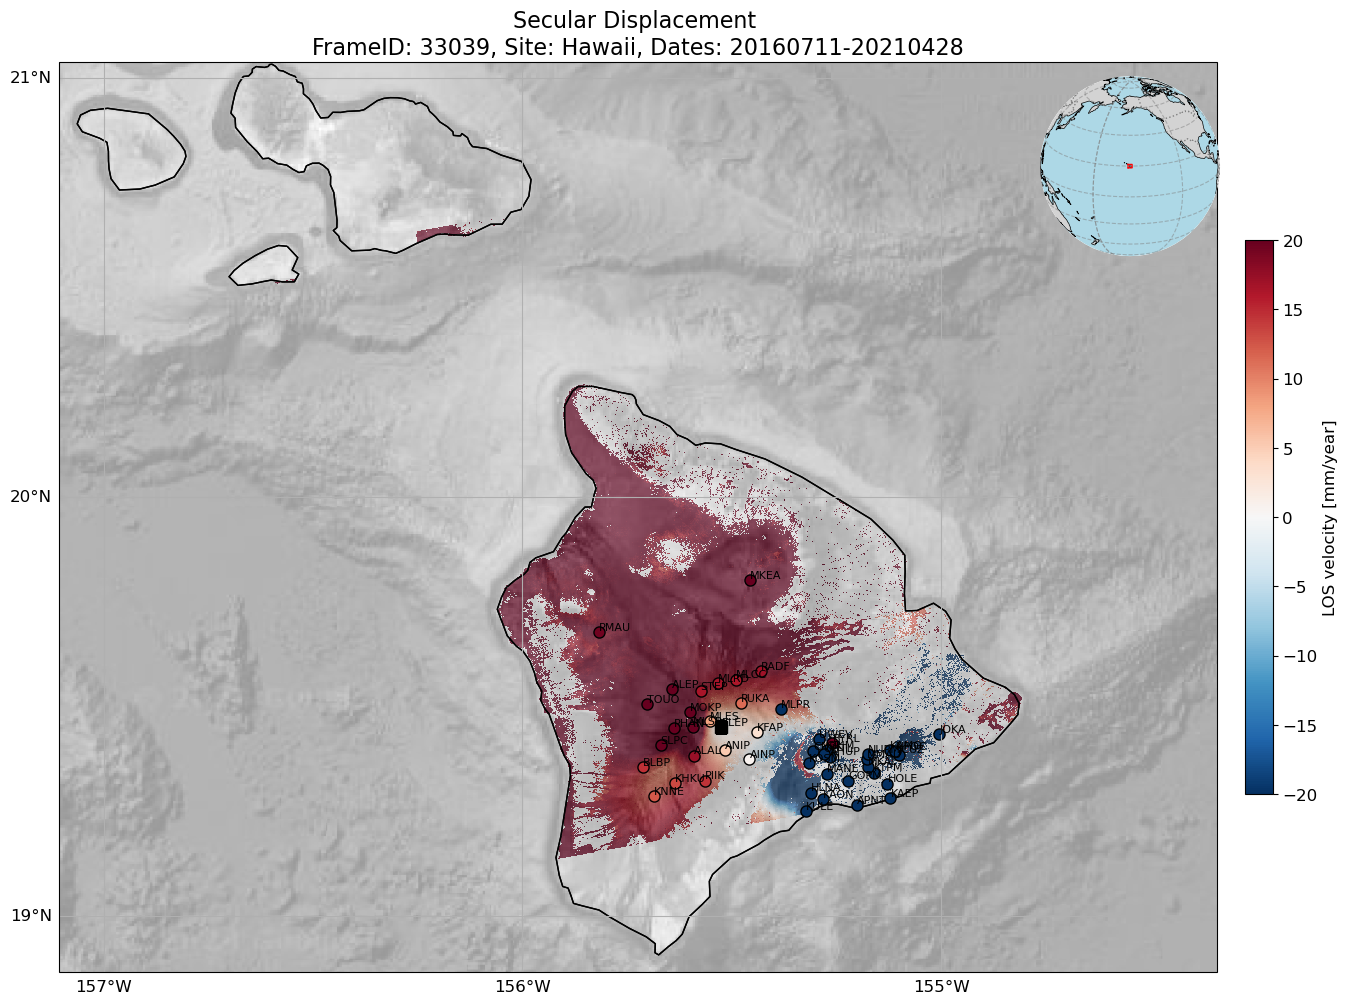

In [17]:
# reference GNSS stations to GNSS reference site
ref_site = sites_df[sites_df["site"]==site]["gps_ref_site_name"].values[0]
ref_site_ind = site_names.index(ref_site)
gnss_velocities = gnss_velocities - gnss_velocities[ref_site_ind]

# reference disp_s1 to GNSS reference site
ref_site_lat = float(site_lats_wgs84[ref_site_ind])
ref_site_lon = float(site_lons_wgs84[ref_site_ind])
ref_site_north = float(site_north[ref_site_ind])
ref_site_east = float(site_east[ref_site_ind])

ref_y, ref_x = ut.coordinate(disp_s1_metadata).geo2radar(ref_site_lat, ref_site_lon)[:2]     # x/y location of reference on velocity
if not math.isnan(disp_s1_velocities[ref_y, ref_x]):
    #disp_s1_velocities = disp_s1_velocities - disp_s1_velocities[ref_y, ref_x]
    #Caution: If you expand the radius parameter farther than the bounding grid it will break. 
    #To fix, remove the station in section 4 when the site_names list is filtered
    ref_vel_px_rad = disp_s1_velocities[ref_y-pixel_radius:ref_y+1+pixel_radius, 
                        ref_x-pixel_radius:ref_x+1+pixel_radius]
    ref_disp_s1_site_vel = np.nanmedian(ref_vel_px_rad)
    if np.isnan(ref_disp_s1_site_vel):
        ref_disp_s1_site_vel = 0.
    disp_s1_velocities = disp_s1_velocities - ref_disp_s1_site_vel

satellite_background_flag = True    # if satellite image is used as background

plot_disp_s1_cartopy(disp_s1_velocities, DISP_region, vmin, vmax, site_north, site_east, gnss_velocities, 
                   site, sites_df, site_names, ref_site_north, ref_site_east, 
                   disp_s1_metadata, satellite_background_flag, output_dir)

<a id='secular_nisar_validation'></a>
# 5. NISAR Validation Approach 1: GNSS-DISP-S1 Direct Comparison 


<a id='secular_make_vel'></a>
## 5.1. Make Velocity Residuals at GNSS Locations


In [18]:
#Create dictionary with the stations as the key and all their info as an array 
stn_dict = {}

#Loop over GNSS station locations
for i in range(len(site_names)): 
    # convert GNSS station lat/lon information to velocity x/y grid
    stn_lat = float(site_lats_wgs84[i])
    stn_lon = float(site_lons_wgs84[i])

    y_value, x_value = ut.coordinate(disp_s1_metadata).geo2radar(stn_lat, stn_lon)[:2]
    stn_north = float(site_north[i])
    stn_east = float(site_east[i])
    
    # get velocities and residuals
    gnss_site_vel = gnss_velocities[i]
    #Caution: If you expand the radius parameter farther than the bounding grid it will break. 
    #To fix, remove the station in section 4 when the site_names list is filtered
    vel_px_rad = disp_s1_velocities[y_value-pixel_radius:y_value+1+pixel_radius, 
                     x_value-pixel_radius:x_value+1+pixel_radius]
    disp_s1_site_vel = np.nanmedian(vel_px_rad)
    if not np.isnan(disp_s1_site_vel):        # when only displacement exists
        residual = gnss_site_vel - disp_s1_site_vel

        # populate data structure
        values = [x_value, y_value, disp_s1_site_vel, gnss_site_vel, residual, stn_north, stn_east]
        stn = site_names[i]
        stn_dict[stn] = values

# extract data from structure
res_list = []
disp_s1_site_vels = []
gnss_site_vels = []
north_list = []
east_list = []
site_names_used = []    

for stn in stn_dict.keys(): 
    disp_s1_site_vels.append(stn_dict[stn][2])
    gnss_site_vels.append(stn_dict[stn][3])
    res_list.append(stn_dict[stn][4])
    north_list.append(stn_dict[stn][5])
    east_list.append(stn_dict[stn][6])
    site_names_used.append(stn)

num_stn = len(site_names_used) 
site_names_removed = list(set(site_names) - set(site_names_used))

print(f"The GNSS sites ({num_stn} stations) will be used for residual analysis: \n {site_names_used}")
print(f"The GNSS sites  ({len(site_names_removed)} stations) are removed due to the absence of DISP-S1 velocity: \n {site_names_removed}")

print('Finish creating DISP-S1 residuals at GNSS sites')

The GNSS sites (47 stations) will be used for residual analysis: 
 ['AHUP', 'AINP', 'ALAL', 'ALEP', 'ANIP', 'APNT', 'BLBP', 'BYRL', 'CNPK', 'CRIM', 'ELEP', 'GOPM', 'HLNA', 'HOLE', 'JCUZ', 'JOKA', 'KAEP', 'KAMO', 'KAON', 'KFAP', 'KHKU', 'KNNE', 'KOSM', 'KTPM', 'KULE', 'MANE', 'MKAI', 'MKEA', 'MLCC', 'MLES', 'MLPR', 'MLRD', 'MLSP', 'MMAU', 'MOKP', 'NPOC', 'NUPM', 'OUTL', 'PHAN', 'PIIK', 'PMAU', 'PUKA', 'RADF', 'SLPC', 'STEP', 'TOUO', 'UWEV']
The GNSS sites  (0 stations) are removed due to the absence of DISP-S1 velocity: 
 []
Finish creating DISP-S1 residuals at GNSS sites


<a id='secular_make_velres'></a>
## 5.2. Make Double-Differenced Velocity Residuals


In [19]:
n_gps_sites = len(site_names_used)
diff_res_list = []
stn_dist_list = []

# loop over stations
for i in range(n_gps_sites-1):
    stn1 = site_names_used[i]
    for j in range(i + 1, n_gps_sites):
        stn2 = site_names_used[j]

        # calculate GNSS and DISP-S1 velocity differences between stations
        gps_vel_diff = stn_dict[stn1][3] - stn_dict[stn2][3]
        disp_s1_vel_diff = stn_dict[stn1][2] - stn_dict[stn2][2]

        # calculate GNSS vs DISP-S1 differences (double differences) between stations
        diff_res = gps_vel_diff - disp_s1_vel_diff
        diff_res_list.append(diff_res)

        # get euclidean distance (km) between stations
        # index 5 is northing, 6 is easting
        stn_dist = euclidean_distance(stn_dict[stn1][6], stn_dict[stn1][5], stn_dict[stn2][6], stn_dict[stn2][5])
        stn_dist_list.append(stn_dist)

# Write data for statistical tests
gnss_site_dist = np.array(stn_dist_list)
double_diff_rel_measure = np.array(np.abs(diff_res_list))
ndx = np.argsort(gnss_site_dist)

<div class="alert alert-warning">
Final result Method 1—Successful when 68% of points below requirements line
</div>


<a id='secular_valid_method1'></a>
## 5.3. Secular Requirement Validation: Method 1


In [20]:
# Statistics
n_bins = 10
threshold = 0.683  
#  we assume that the distribution of residuals is Gaussian and 
#  that the threshold represents a 1-sigma limit within which 
#  we expect 68.3% of residuals to lie.

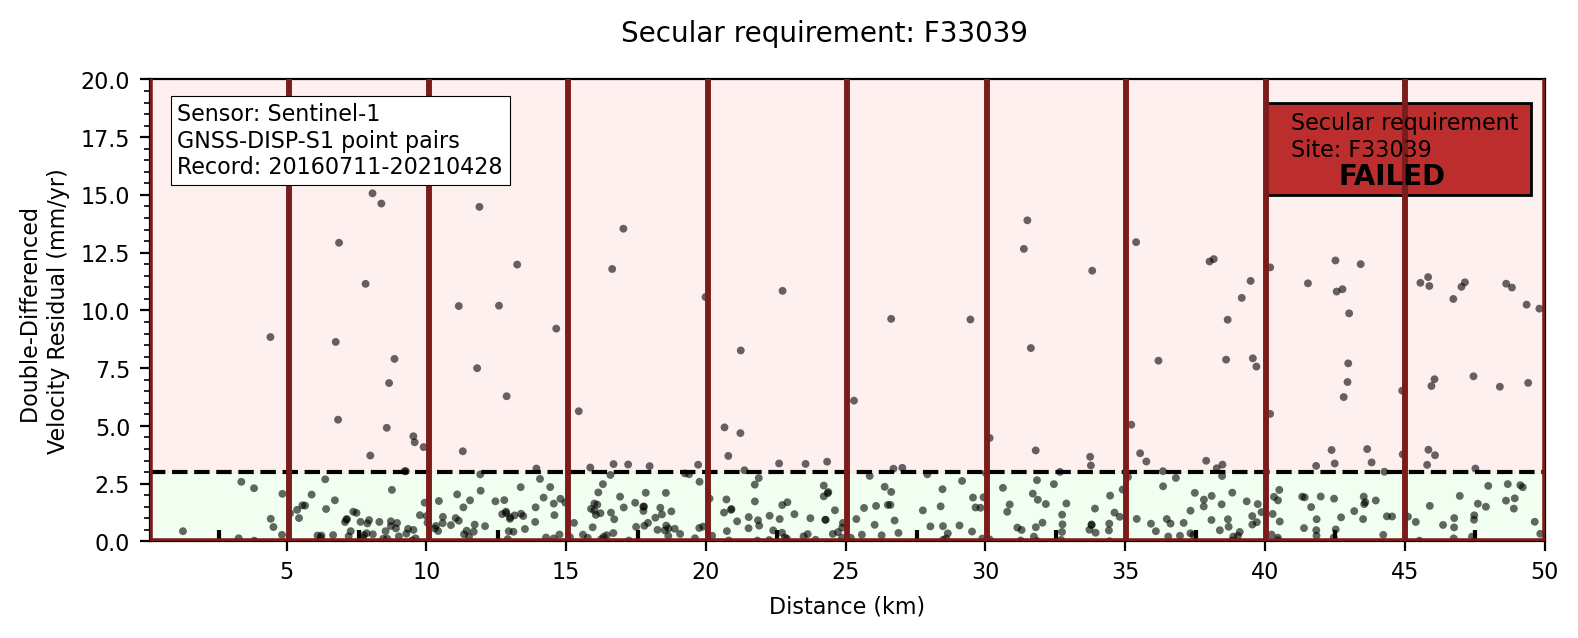

In [21]:
validation_table, fig = display_validation(gnss_site_dist,                 # binned distance for point
                                           double_diff_rel_measure,        # binned double-difference velocities mm/yr
                                           site,                           # cal/val site name
                                           start_date,                     # start date of disp_s1 dataset
                                           end_date,                       # end date of disp_s1 dataset 
                                           requirement=secular_gnss_rqmt,  # measurement requirement to meet, e.g 2 mm/yr for 3 years of data over 0.1-50km
                                           distance_rqmt=gnss_dist_rqmt,   # distance over requirement is to meet, e.g. over length scales of 0.1-50 km [0.1, 50] 
                                           n_bins=n_bins,                  # number of bins, to collect statistics 
                                           threshold=threshold,            # quantile threshold for point-pairs that pass requirement, e.g. 0.683 - we expect 68.3% of residuals to lie. 
                                           sensor='Sentinel-1',            # sensor that is validated, Sentinel-1 or NISAR
                                           validation_type='secular',      # validation for: secular, transient, coseismic requirement
                                           validation_data='GNSS')         # validation method: GNSS - Method 1, disp_s1 - Method 2

out_fig = f'{output_dir}/VA1_secular_disp_s1-gnss_velocity_vs_distance_site{site}_date{disp_s1_metadata["START_DATE"]}-{disp_s1_metadata["END_DATE"]}.png'
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

In [22]:
display_validation_table(validation_table)

This velocity dataset does not pass the requirement.


In [23]:
# generating csv and html files containing validation results
validation_table.to_csv(f'{output_dir}/VA1_secular_disp_s1-gnss_velocity_vs_distance_table_site{site}_date{disp_s1_metadata["START_DATE"]}-{disp_s1_metadata["END_DATE"]}.csv')

html = display_validation_table(validation_table).background_gradient().to_html()
html_filename = f'{output_dir}/VA1_secular_disp_s1-gnss_velocity_vs_distance_table_site{site}_date{disp_s1_metadata["START_DATE"]}-{disp_s1_metadata["END_DATE"]}.html'
with open(html_filename, "w") as f:
    f.write(html)

This velocity dataset does not pass the requirement.


In [24]:
options = {
    'format': 'png',
    'encoding': "UTF-8",
    'zoom': 2  # Increase this value for higher resolution
}

png_filename = f'{output_dir}/VA1_secular_disp_s1-gnss_velocity_vs_distance_table_site{site}_date{disp_s1_metadata["START_DATE"]}-{disp_s1_metadata["END_DATE"]}.png'
imgkit.from_file(html_filename, png_filename, options=options)


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

<div class="alert alert-warning">
Final result Method 1 table by distance bin—successful when greater than 0.683
</div>


<a id='secular_nisar_validation2'></a>
# 6. NISAR Validation Approach 2: InSAR-only Structure Function

In Validation approach 2, we use a time interval and area where we assume no deformation.

<a id='secular_array_mask'></a>
## 6.1. Read Array and Mask Pixels with no Data

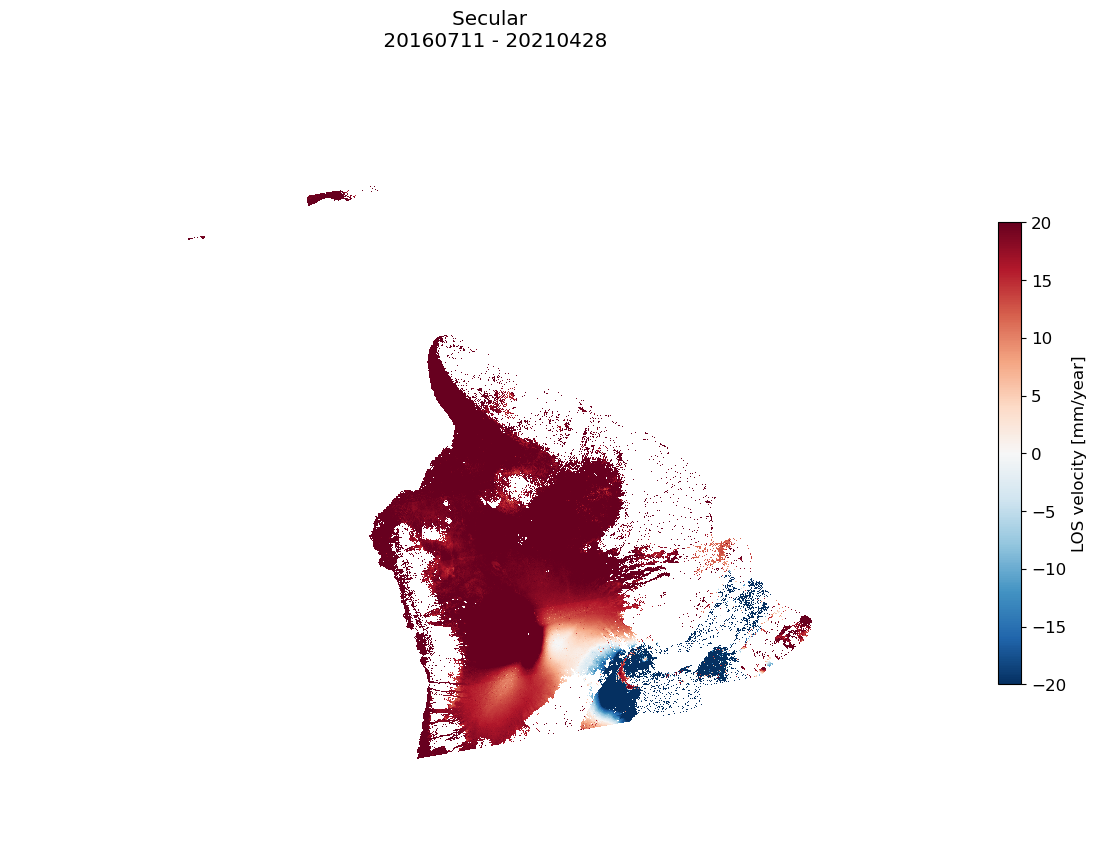

In [25]:
# use the assumed non-earthquake displacement as the disp_s1_displacment for statistics and convert to mm
velStart = start_date
velEnd = end_date

# display map of data after masking
cmap = plt.get_cmap('RdBu_r')

fig, ax = plt.subplots(figsize=[15, 15])
im = ax.imshow(disp_s1_velocities, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest')
cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02, shrink=0.4)
cbar.set_label('LOS velocity [mm/year]')
ax.set_title(f"Secular \n {velStart} - {velEnd}")
ax.axis('off')
plt.show()

<a id='secular_remove_trend'></a>
## 6.2. Randomly Sample Pixels and Pair Them Up with Option to Remove Trend

In [26]:
sample_mode = 'points'  # 'points' or 'profile'
# note that the 'profile' method may take significantly longer even with multi processing

X0,Y0 = load_geo_utm(disp_s1_metadata)
X0_2d,Y0_2d = np.meshgrid(X0,Y0)

# Collect samples using the specified method
if sample_mode in ['points']:

    disp_s1_sample_dist, disp_s1_rel_measure = samp_pair(X0_2d, Y0_2d, disp_s1_velocities, num_samples=1000000)
    disp_s1_sample_dist /= 1000   # unit: to km
    
elif sample_mode in ['profile']:

    disp_s1_sample_dist, disp_s1_rel_measure = profile_samples_utm(X0_2d.reshape(-1), Y0_2d.reshape(-1), disp_s1_velocities.reshape(-1), len_rqmt=disp_s1_dist_rqmt, num_samples=6000)
    
print('Finished sampling')

Finished sampling


Text(0, 0.5, 'Frequency')

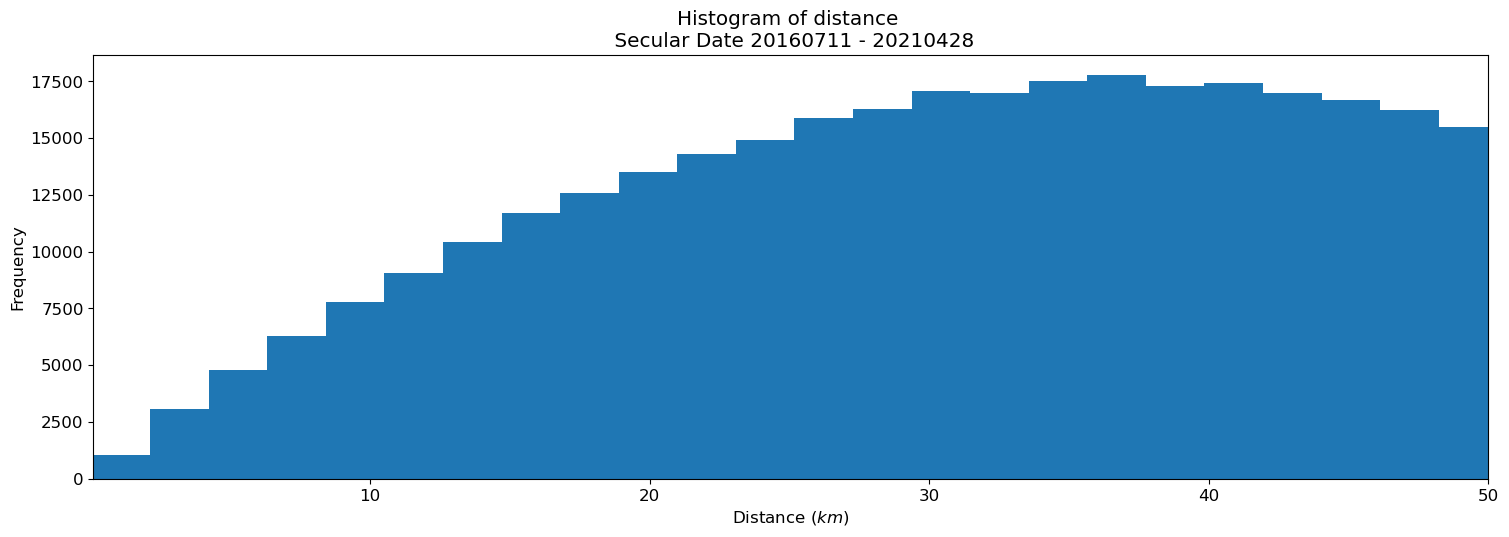

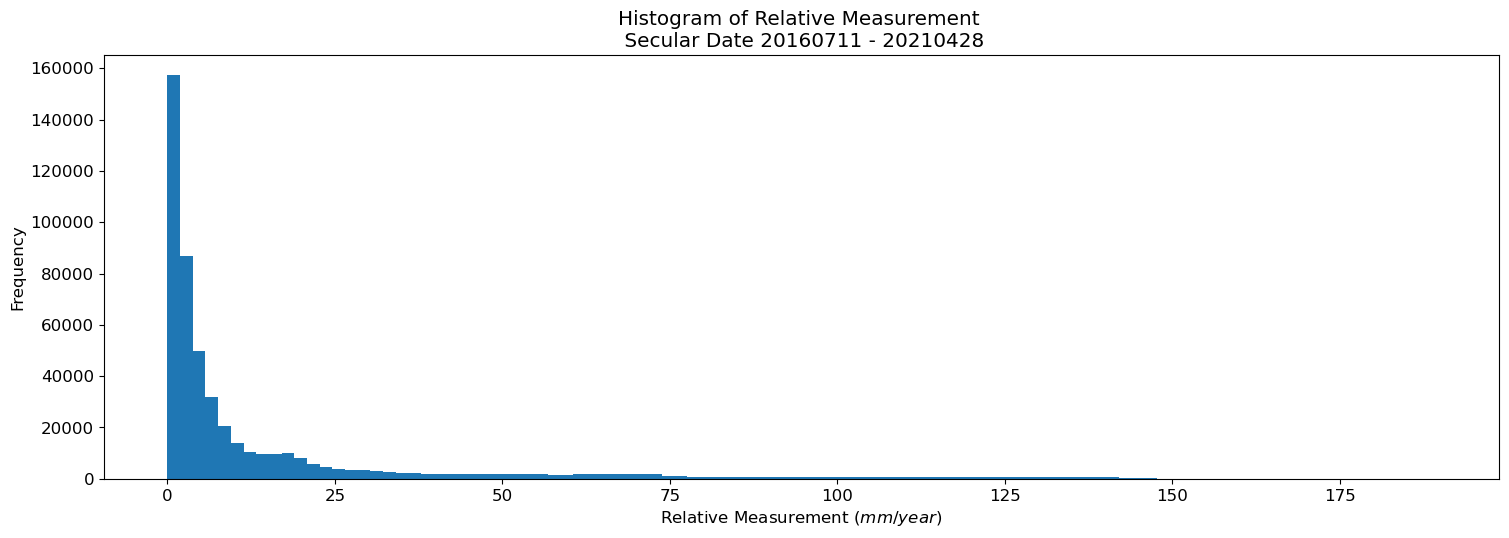

In [27]:
fig, ax = plt.subplots(figsize=[18, 5.5])
img1 = ax.hist(disp_s1_sample_dist, bins=100)
ax.set_title("Histogram of distance \n Secular Date {:s} - {:s}".format(start_date, end_date))
ax.set_xlabel(r'Distance ($km$)')
ax.set_ylabel('Frequency')
ax.set_xlim(*disp_s1_dist_rqmt)
    
fig, ax = plt.subplots(figsize=[18, 5.5])
img1 = ax.hist(disp_s1_rel_measure, bins=100)
ax.set_title("Histogram of Relative Measurement \n Secular Date {:s} - {:s}".format(start_date, end_date))
ax.set_xlabel(r'Relative Measurement ($mm/year$)')
ax.set_ylabel('Frequency')

<a id='secular_M2ampvsdist2'></a>
## 6.3. Amplitude vs. Distance of Relative Measurements (pair differences)

In [28]:
# Statistics
n_bins = 10
threshold = 0.683  
#  we assume that the distribution of residuals is Gaussian and 
#  that the threshold represents a 1-sigma limit within which 
#  we expect 68.3% of residuals to lie.

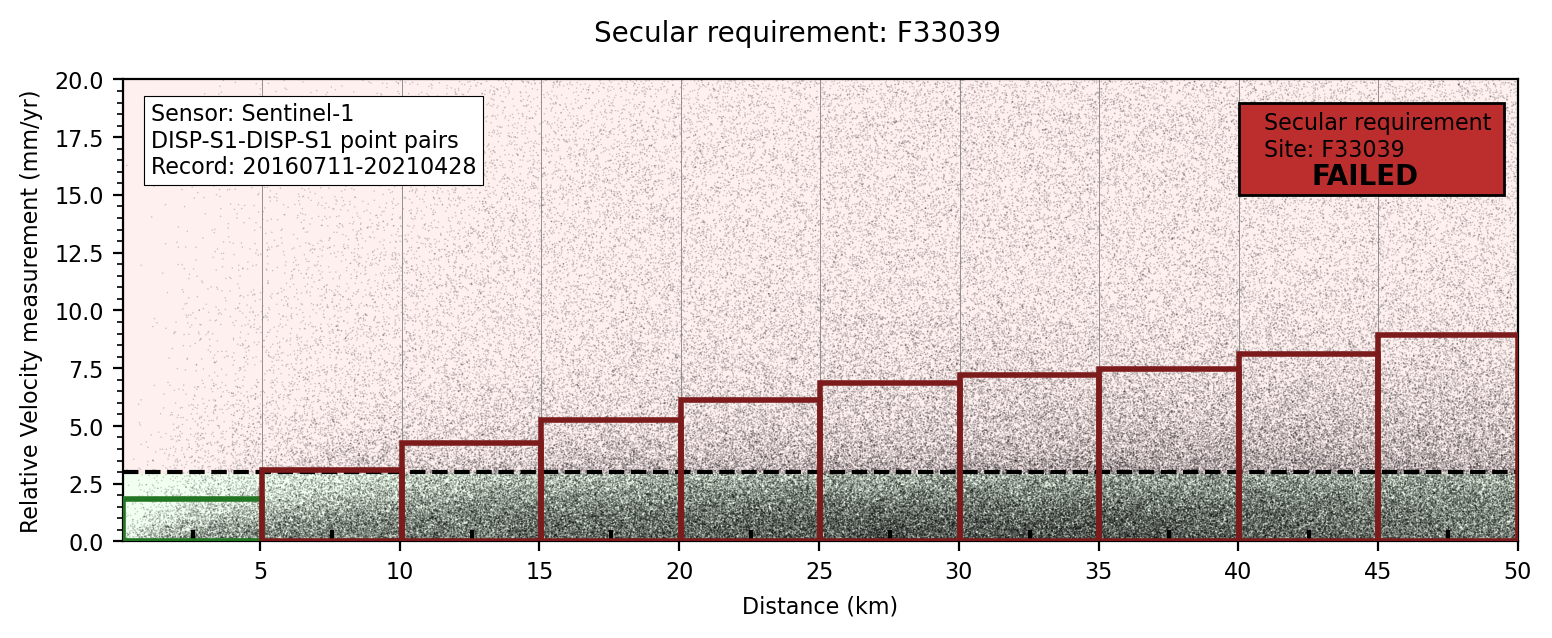

In [29]:
validation_table, fig = display_validation(disp_s1_sample_dist,              # binned distance for point
                                           disp_s1_rel_measure,              # binned relative velocities mm/yr
                                           site,                           # cal/val site name
                                           start_date,                     # start date of InSAR dataset
                                           end_date,                       # end date of InSAR dataset 
                                           requirement=secular_disp_s1_rqmt,  # measurement requirement to meet, e.g 2 mm/yr for 3 years of data over 0.1-50km
                                           distance_rqmt=disp_s1_dist_rqmt,   # distance over requirement is to meet, e.g. over length scales of 0.1-50 km [0.1, 50] 
                                           n_bins=n_bins,                  # number of bins, to collect statistics 
                                           threshold=threshold,            # quantile threshold for point-pairs that pass requirement, e.g. 0.683 - we expect 68.3% of residuals to lie. 
                                           sensor='Sentinel-1',            # sensor that is validated, Sentinel-1 or NISAR
                                           validation_type='secular',      # validation for: secular, transient, coseismic requirement
                                           validation_data='DISP-S1')         # validation method: GNSS - Method 1, DISP-S1 - Method 2

out_fig = f'{output_dir}/VA2_secular_DISP-S1-only_vs_distance_site{site}_date{disp_s1_metadata["START_DATE"]}-{disp_s1_metadata["END_DATE"]}.png'
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

<div class="alert alert-warning">
Final result Method 2—
    68% of points below the requirements line is success
</div>


<a id='secular_M2RelMeasTable'></a>
## 6.4. Bin Sample Pairs by Distance Bin and Calculate Statistics

In [30]:
display_validation_table(validation_table)

This velocity dataset does not pass the requirement.


In [31]:
# generating csv and html files containing validation results
validation_table.to_csv(f'{output_dir}/VA2_secular_DISP-S1-only_vs_distance_site{site}_date{disp_s1_metadata["START_DATE"]}-{disp_s1_metadata["END_DATE"]}.csv')

html = display_validation_table(validation_table).background_gradient().to_html()
html_filename = f'{output_dir}/VA2_secular_DISP-S1-only_vs_distance_site{site}_date{disp_s1_metadata["START_DATE"]}-{disp_s1_metadata["END_DATE"]}.html'
with open(html_filename, "w") as f:
    f.write(html)

This velocity dataset does not pass the requirement.


In [32]:
options = {
    'format': 'png',
    'encoding': "UTF-8",
    'zoom': 2  # Increase this value for higher resolution
}

png_filename = f'{output_dir}/VA2_secular_DISP-S1-only_vs_distance_site{site}_date{disp_s1_metadata["START_DATE"]}-{disp_s1_metadata["END_DATE"]}.png'
imgkit.from_file(html_filename, png_filename, options=options)


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

<div class="alert alert-warning">
Final result Method 2 table of distance bins—
    68% (0.683) of points below the requirements line is success
</div>


<a id='secular_appendix1'></a>
# Appendix: Supplementary Comparisons and Plots

<a id='secular_compare_raw'></a>
## A.1. Compare Raw Velocities

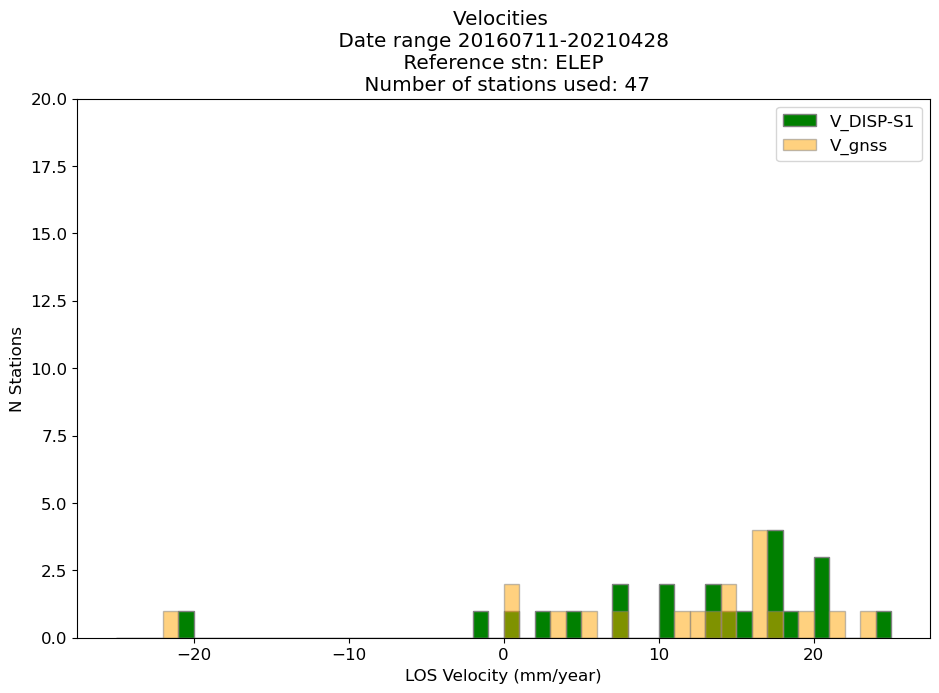

In [33]:
vmin, vmax = -25, 25
plt.figure(figsize=(11,7))
plt.hist(disp_s1_site_vels, range=[vmin, vmax], bins=50, color="green", edgecolor='grey', label='V_DISP-S1')
plt.hist(gnss_site_vels, range=[vmin, vmax], bins=50, color="orange", edgecolor='grey', label='V_gnss', alpha=0.5)
plt.legend(loc='upper right')
plt.title(f"Velocities \n Date range {start_date}-{end_date} \n Reference stn: {ref_site} \n Number of stations used: {num_stn}")
plt.xlabel('LOS Velocity (mm/year)')
plt.ylabel('N Stations')
plt.ylim(0,20)
plt.show()

<a id='secular_plot_vel'></a>
## A.2. Plot Velocity Residuals


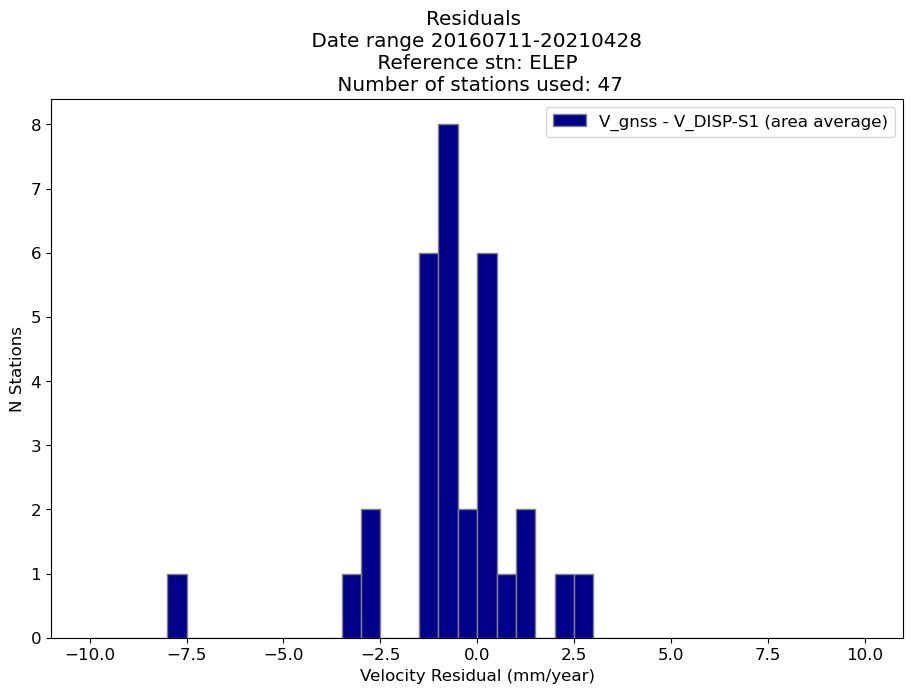

In [34]:
vmin, vmax = -10, 10
plt.figure(figsize=(11,7))
plt.hist(res_list, bins = 40, range=[vmin,vmax], edgecolor='grey', color="darkblue", linewidth=1, label='V_gnss - V_DISP-S1 (area average)')
plt.legend(loc='upper right')
plt.title(f"Residuals \n Date range {start_date}-{end_date} \n Reference stn: {ref_site} \n Number of stations used: {num_stn}")
plt.xlabel('Velocity Residual (mm/year)')
plt.ylabel('N Stations')
plt.show()

<a id='secular_plot_velres'></a>
## A.3. Plot Double Difference Residuals

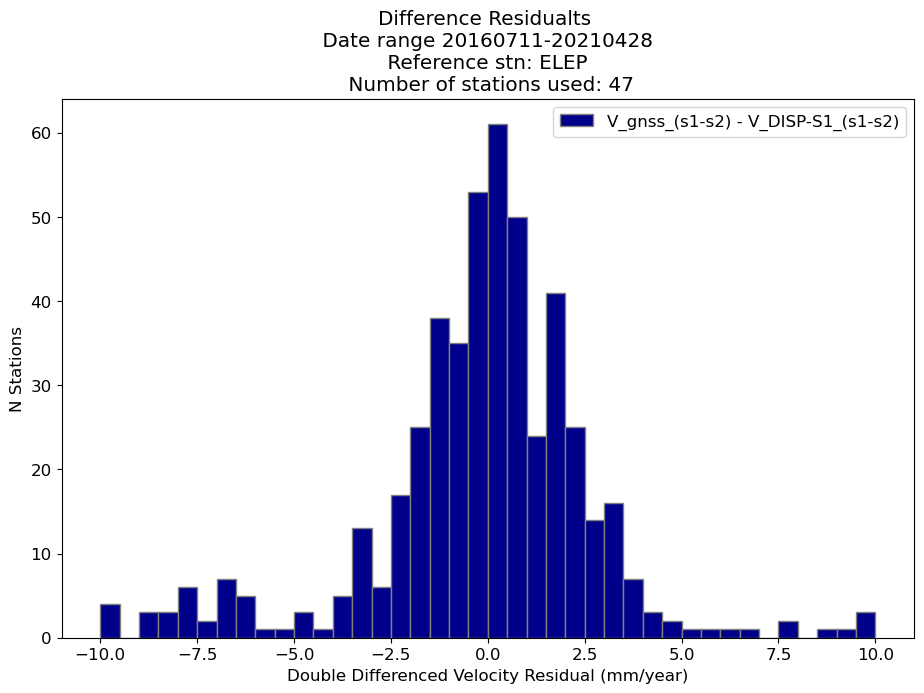

In [35]:
plt.figure(figsize=(11,7))
plt.hist(diff_res_list, range = [vmin, vmax],bins = 40, color = "darkblue",edgecolor='grey',label='V_gnss_(s1-s2) - V_DISP-S1_(s1-s2)')
plt.legend(loc='upper right')
plt.title(f"Difference Residualts \n Date range {start_date}-{end_date} \n Reference stn: {ref_site} \n Number of stations used: {num_stn}")
plt.xlabel('Double Differenced Velocity Residual (mm/year)')
plt.ylabel('N Stations')
plt.show()

<a id='secular_appendix_gps'></a>
## A.4. GNSS Timeseries Plots


reading timeseries from file: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F33039/mintpy_output/timeseries.h5
[======================= 47%                       ] ['AHUP', 'AINP', 'ALAL', 'ALEP', 'ANIP', 'APNT', 'BLBP', 'BYRL', 'CNPK', 'CRIM', 'ELEP', 'GOPM', 'HLNA', 'HOLE', 'JCUZ', 'JOKA', 'KAEP', 'KAMO', 'KAON', 'KFAP', 'KHKU', 'KNNE', 'KOSM', 'KTPM', 'KULE', 'MANE', 'MKAI', 'MKEA', 'MLCC', 'MLES', 'MLPR', 'MLRD', 'MLSP', 'MMAU', 'MOKP', 'NPOC', 'NUPM', 'OUTL', 'PHAN', 'PIIK', 'PMAU', 'PUKA', 'RADF', 'SLPC', 'STEP', 'TOUO', 'UWEV'] 22/47    6s /     7s

/tmp/ipykernel_2166079/352775754.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(12, 3))


[==================================================] ['AHUP', 'AINP', 'ALAL', 'ALEP', 'ANIP', 'APNT', 'BLBP', 'BYRL', 'CNPK', 'CRIM', 'ELEP', 'GOPM', 'HLNA', 'HOLE', 'JCUZ', 'JOKA', 'KAEP', 'KAMO', 'KAON', 'KFAP', 'KHKU', 'KNNE', 'KOSM', 'KTPM', 'KULE', 'MANE', 'MKAI', 'MKEA', 'MLCC', 'MLES', 'MLPR', 'MLRD', 'MLSP', 'MMAU', 'MOKP', 'NPOC', 'NUPM', 'OUTL', 'PHAN', 'PIIK', 'PMAU', 'PUKA', 'RADF', 'SLPC', 'STEP', 'TOUO', 'UWEV'] 47/47   14s /     0s 


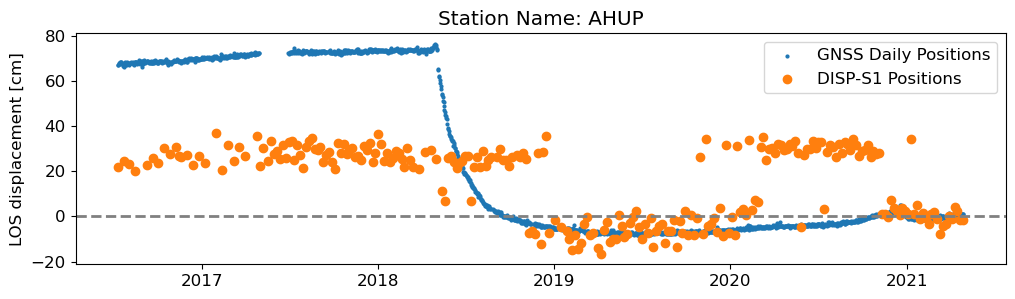

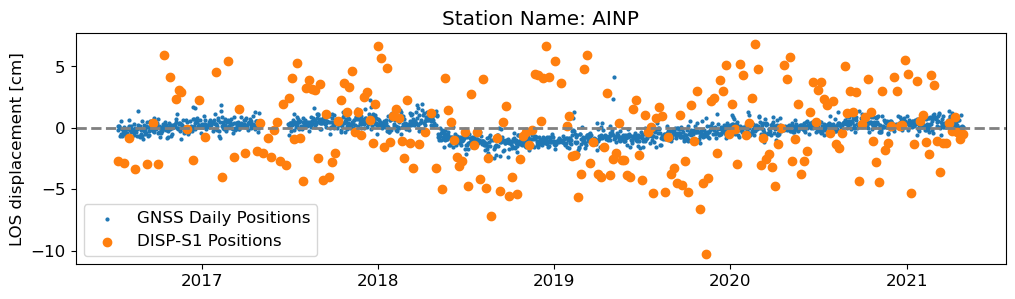

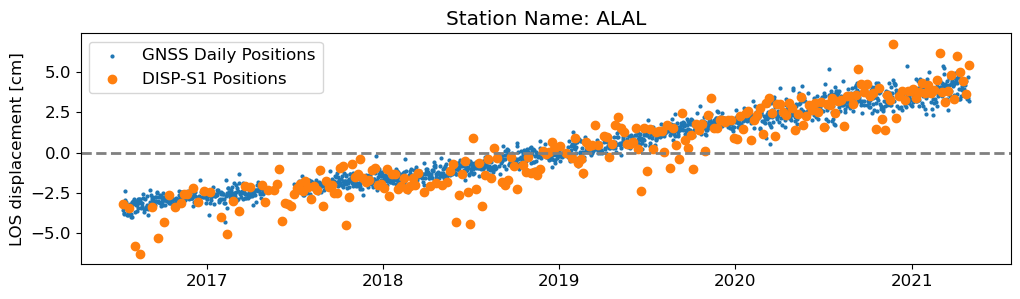

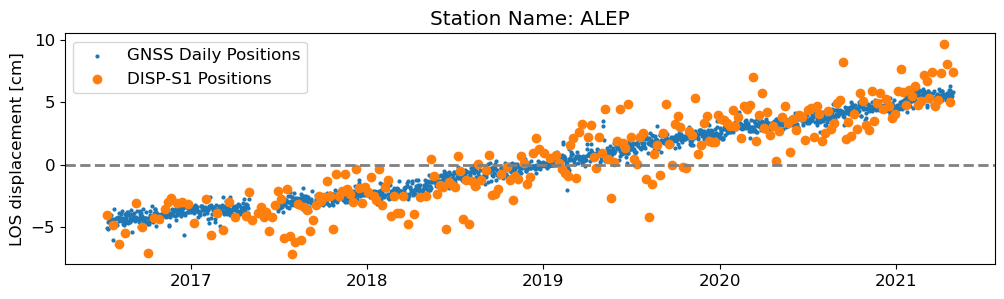

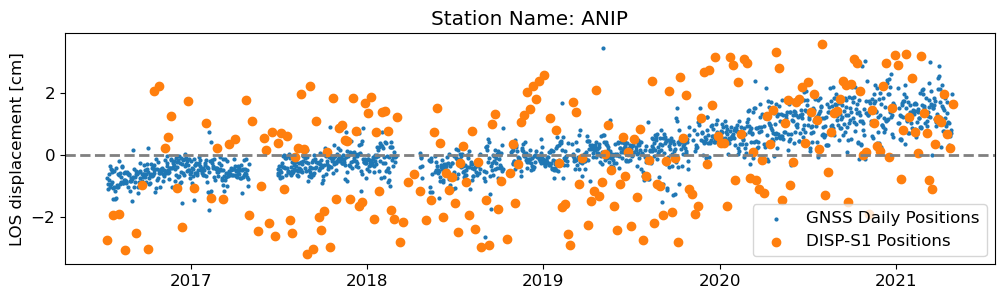

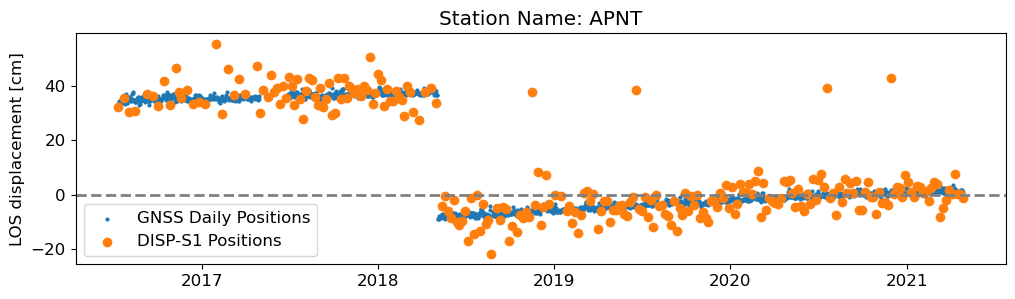

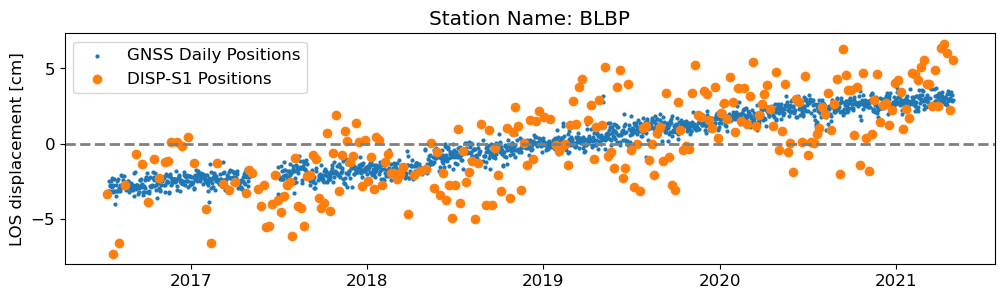

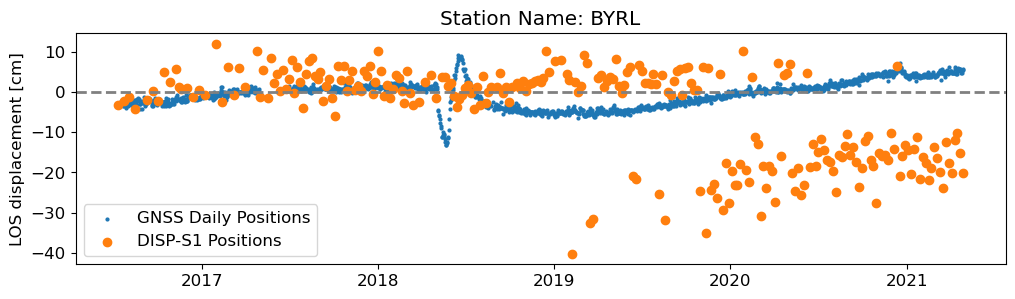

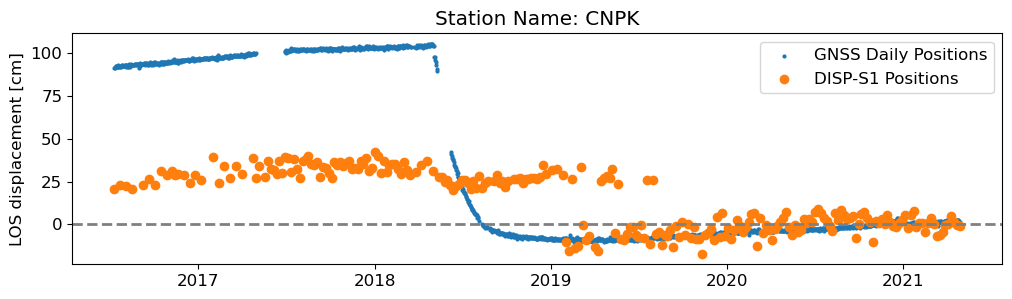

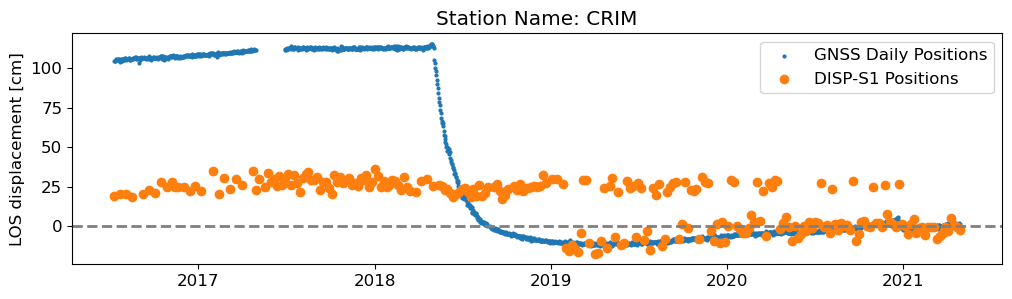

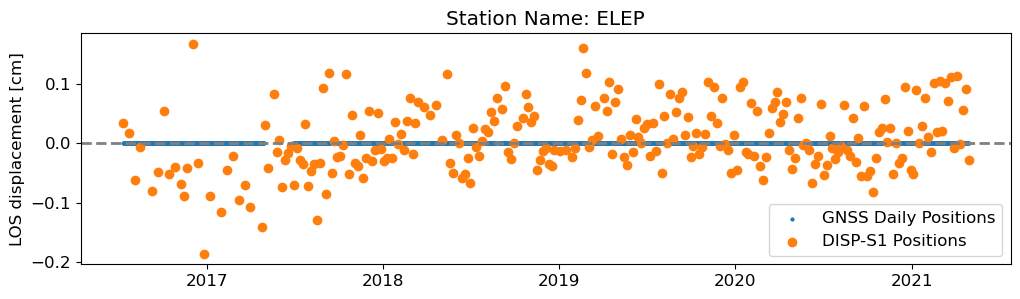

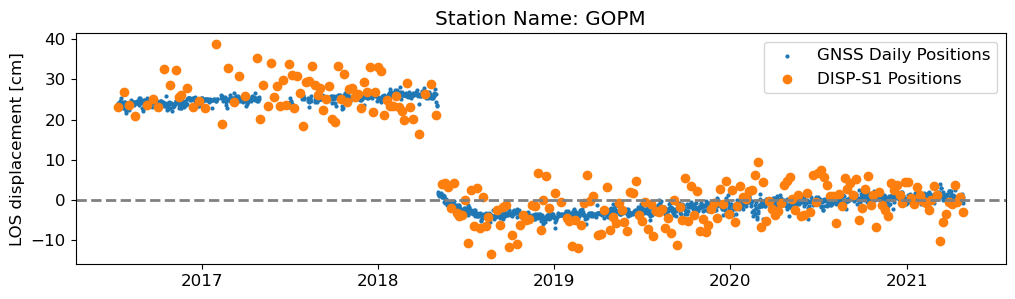

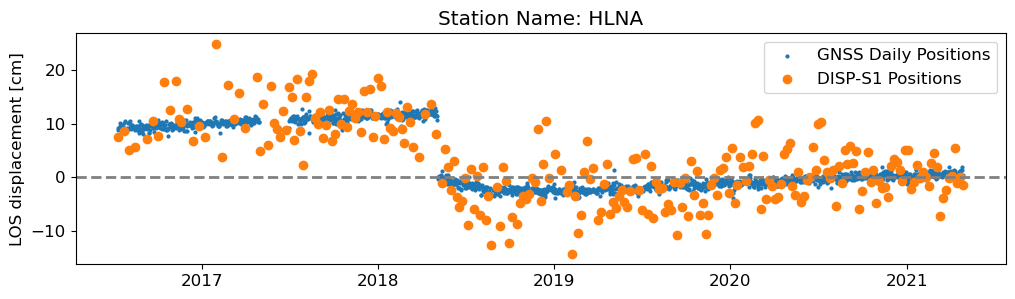

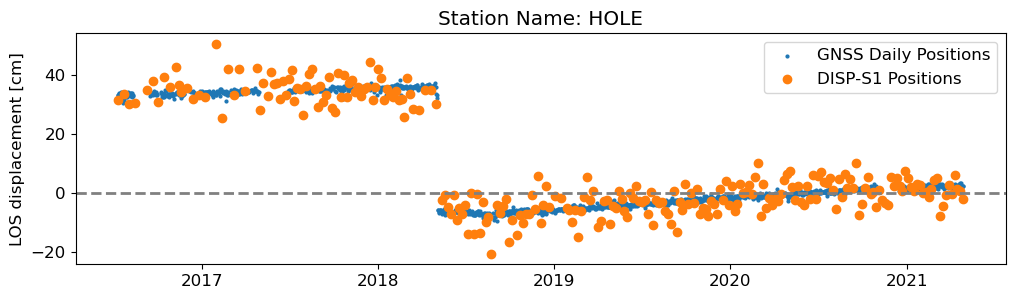

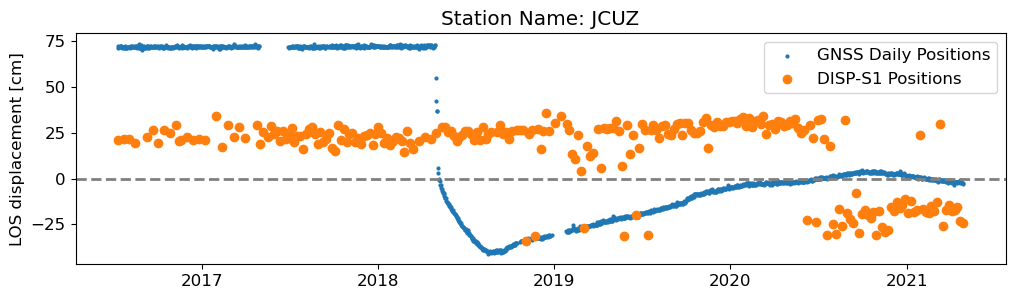

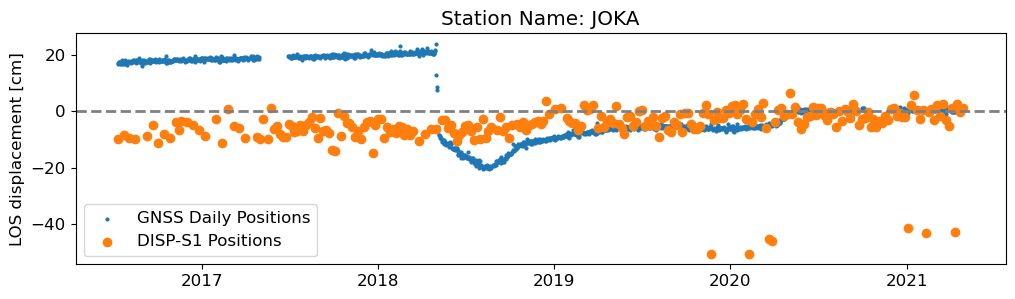

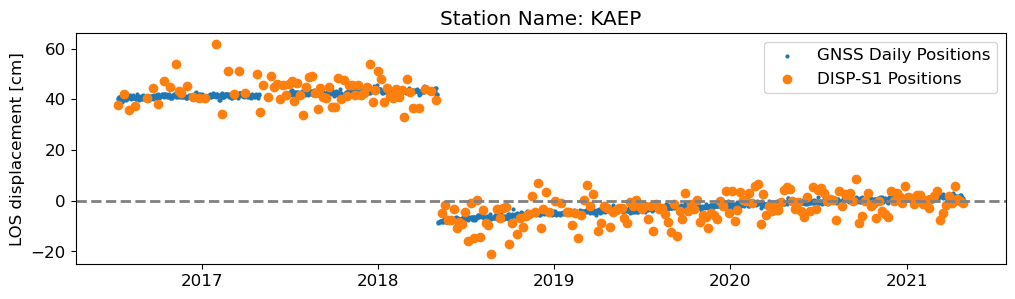

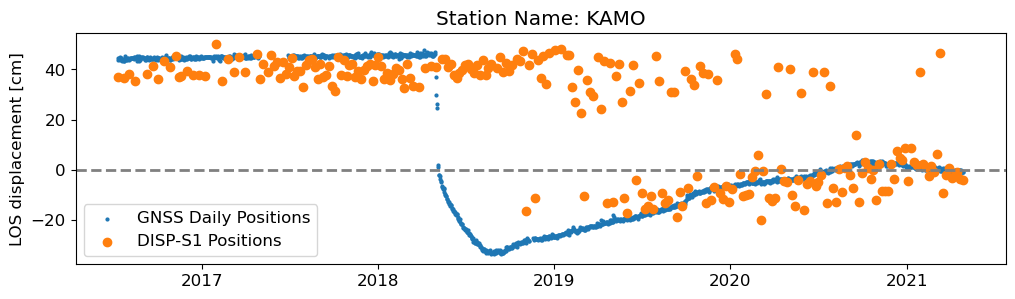

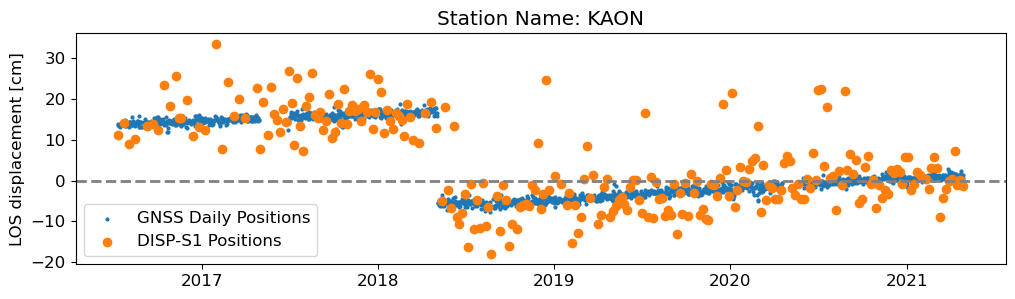

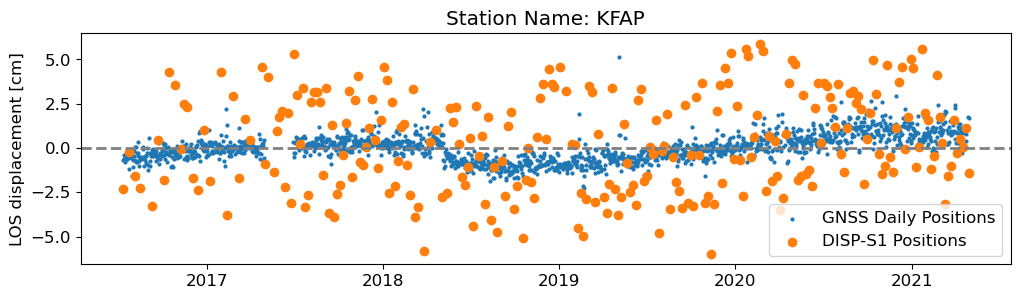

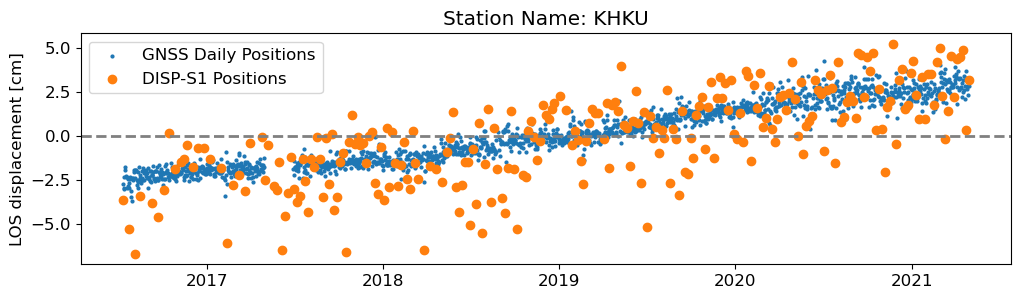

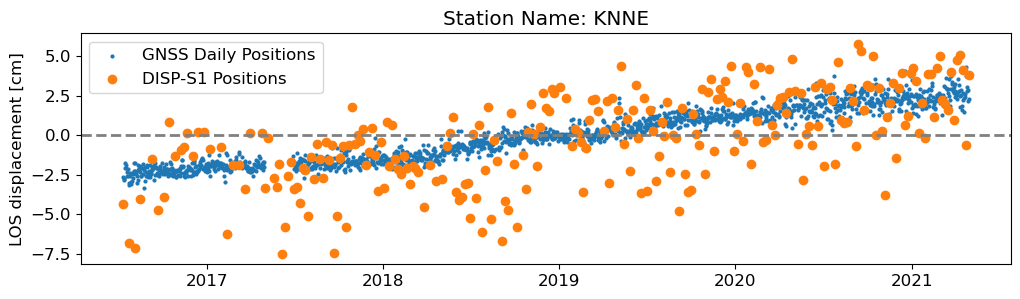

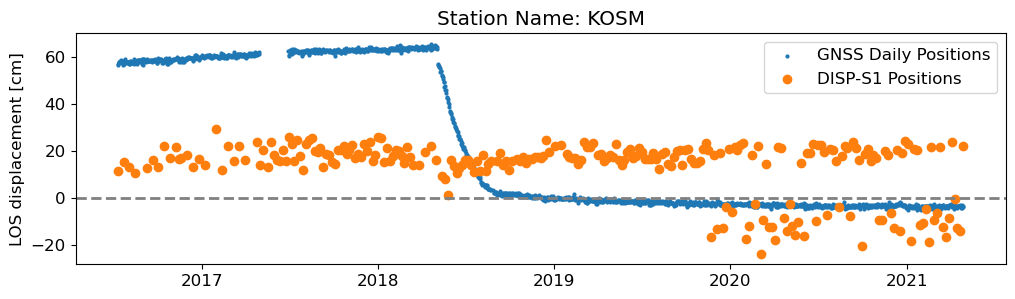

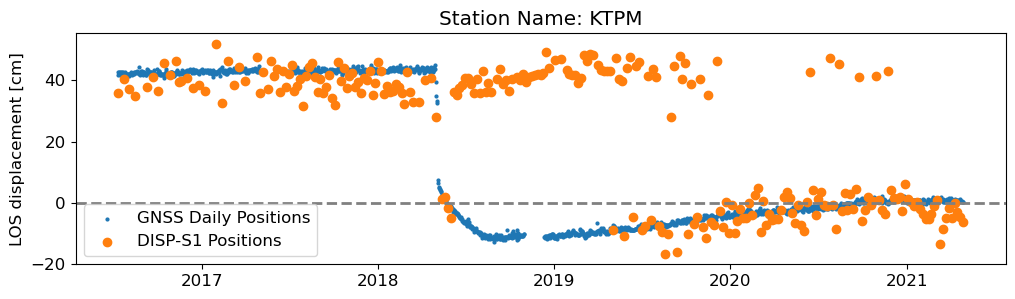

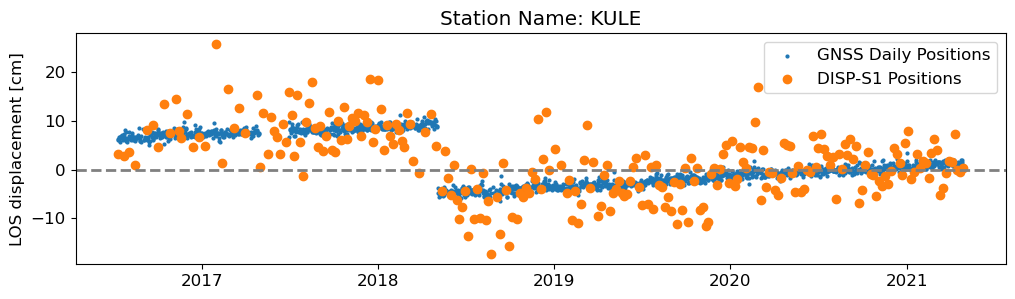

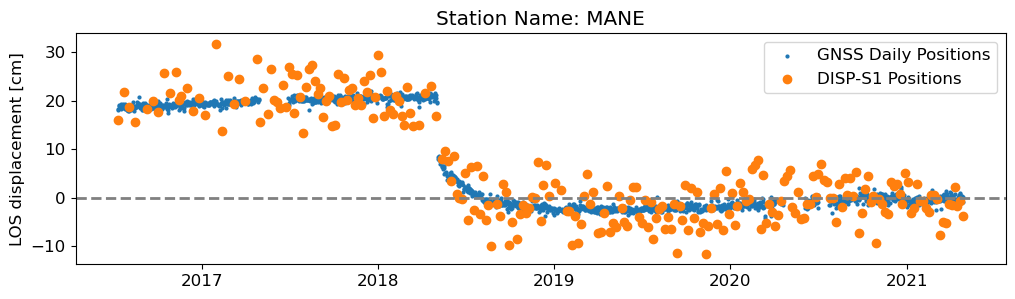

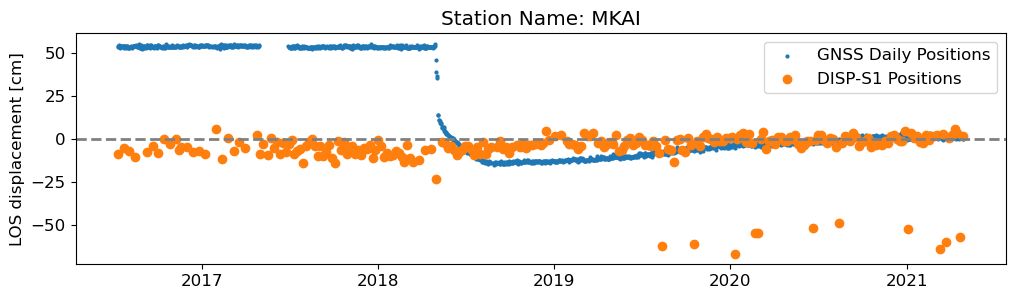

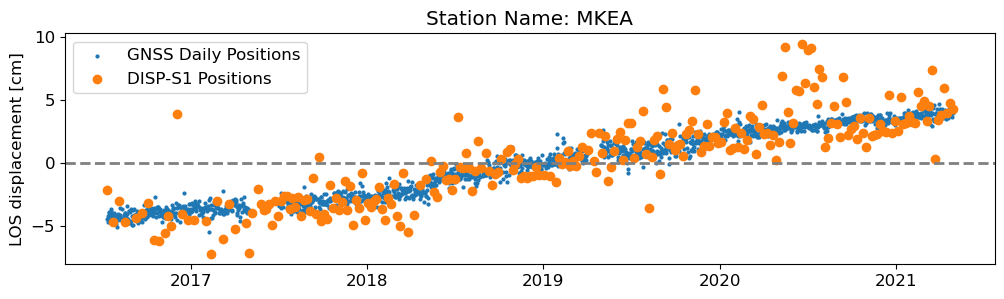

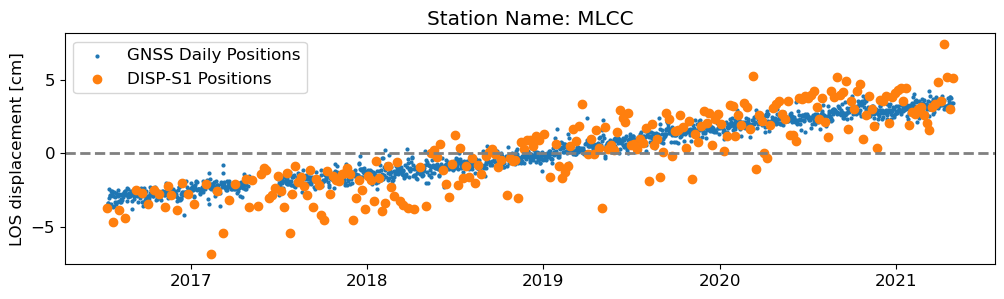

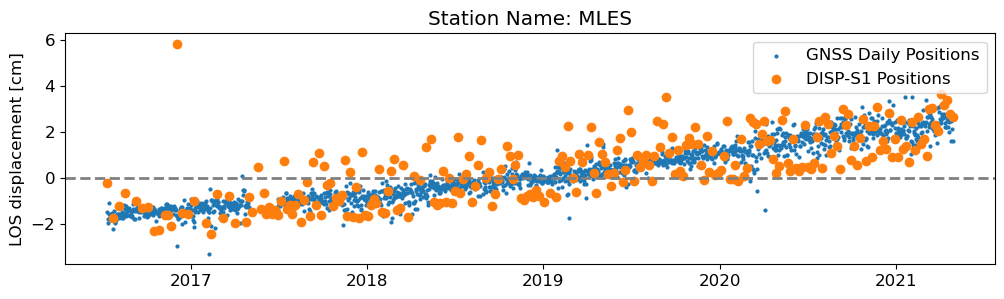

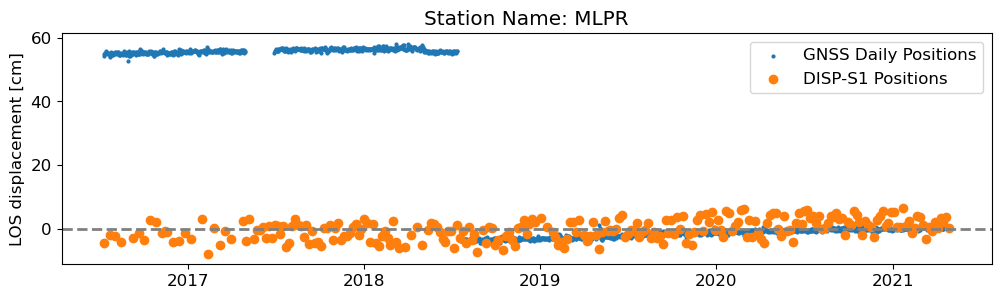

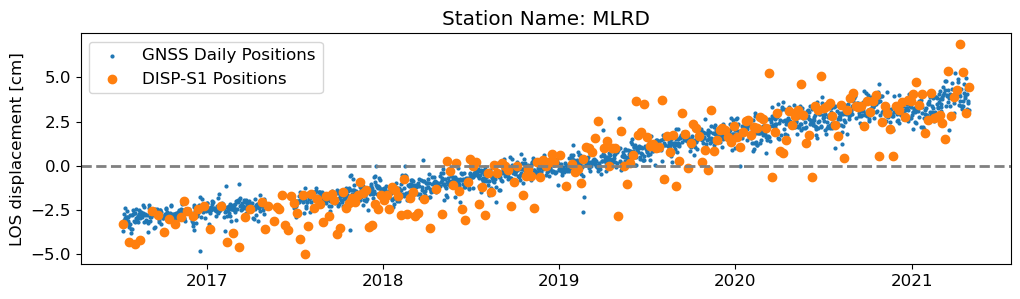

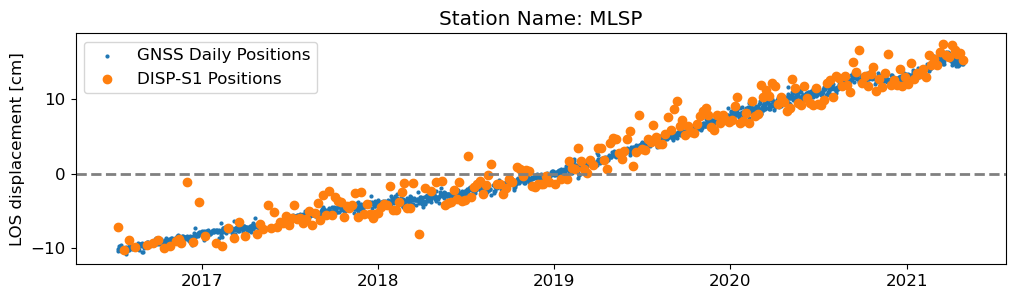

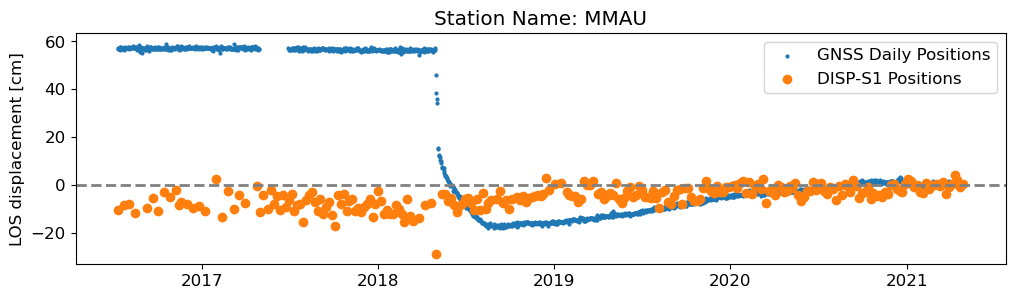

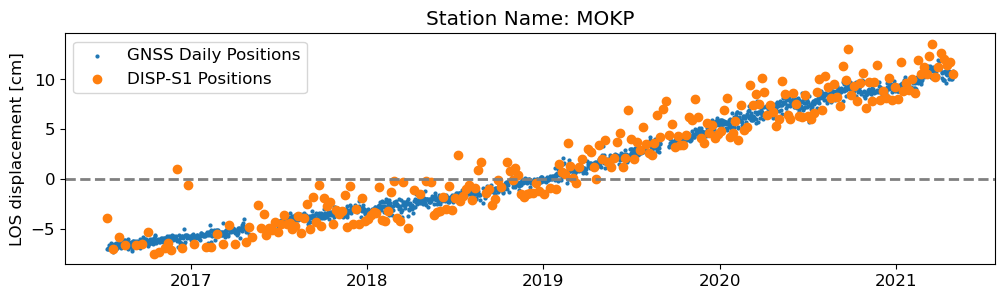

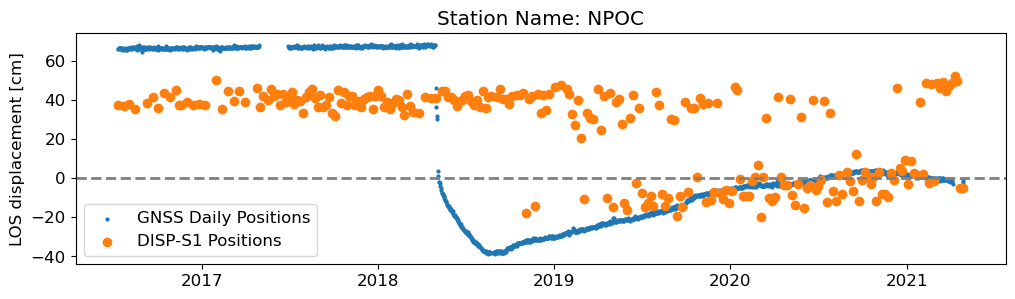

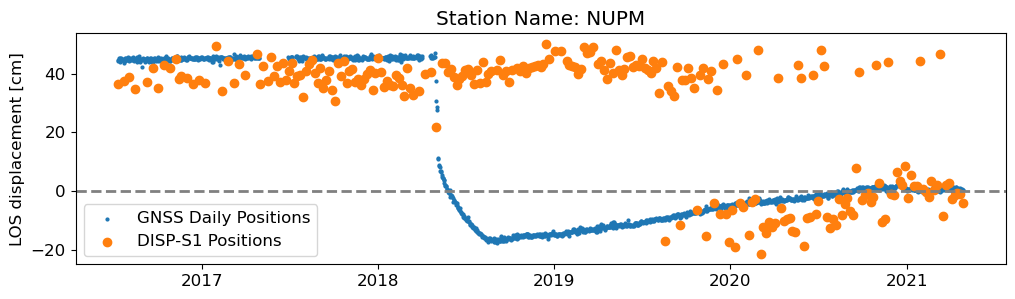

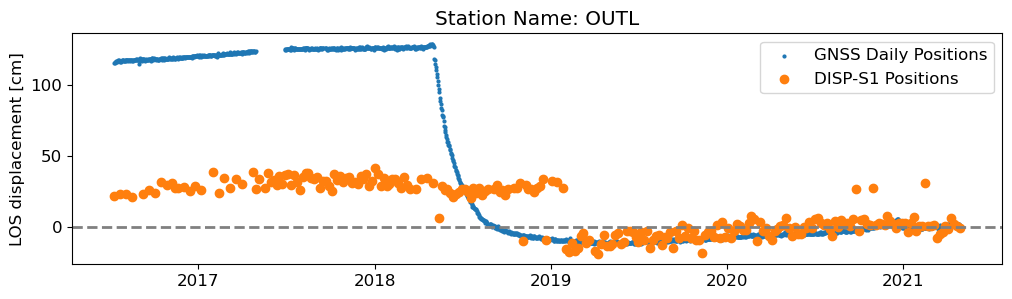

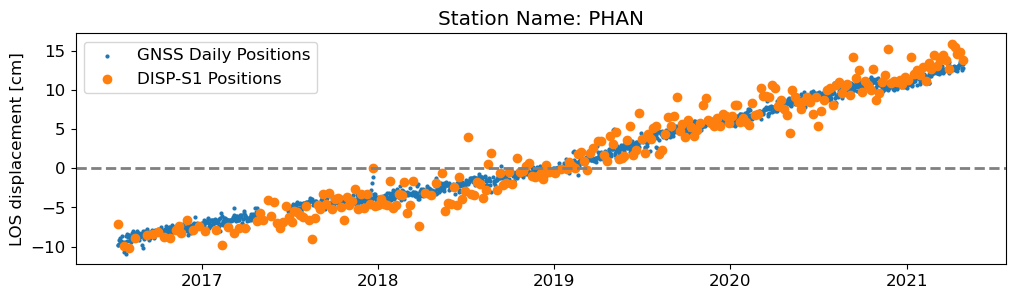

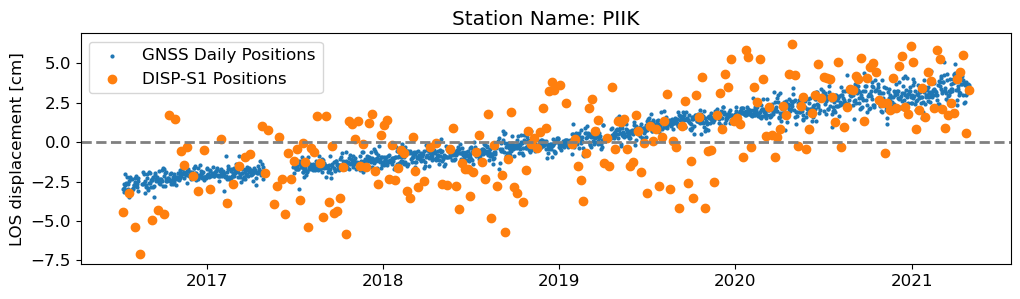

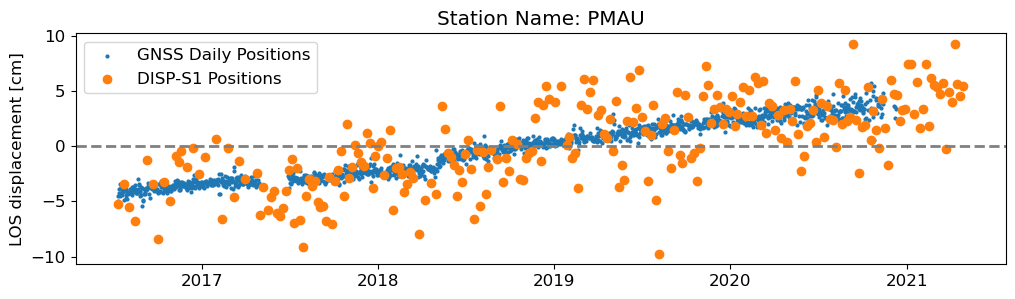

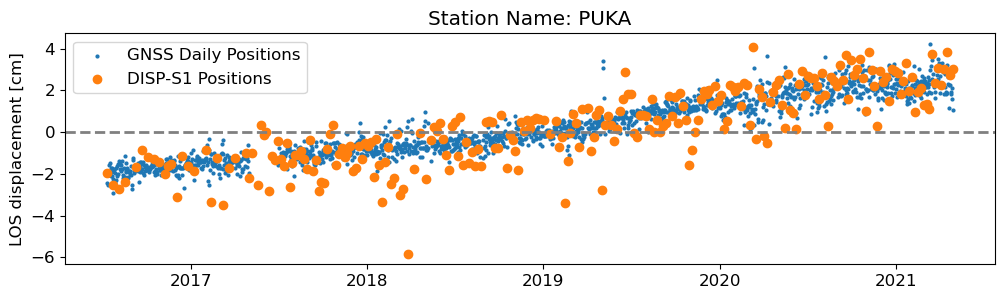

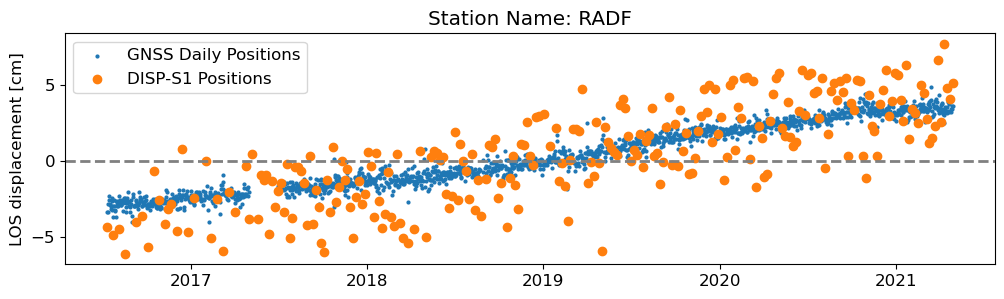

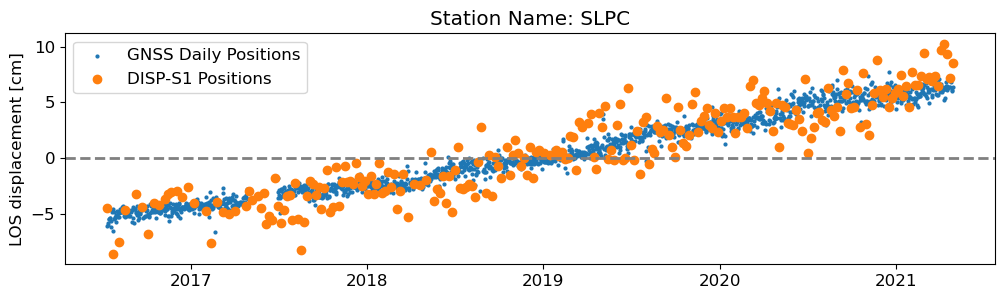

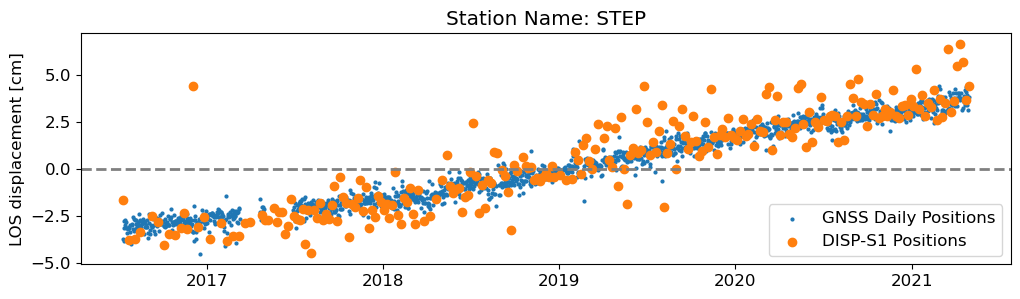

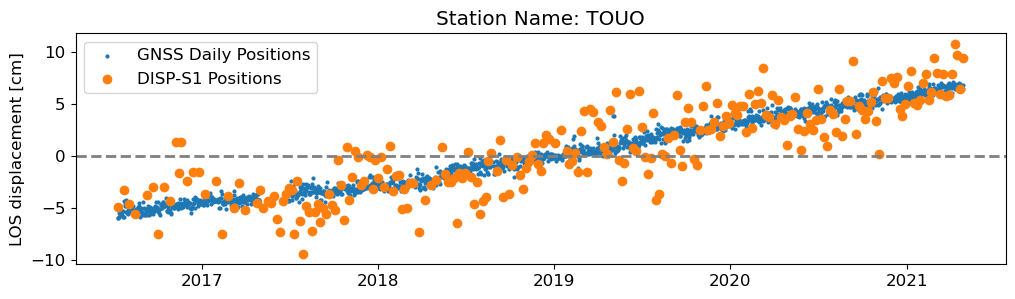

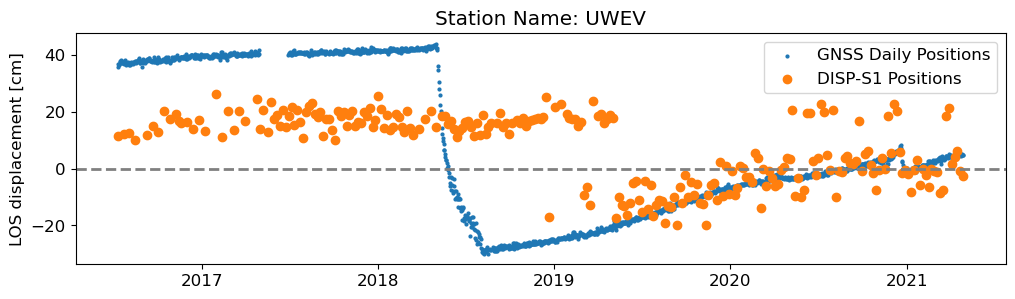

In [36]:
gnss_ts_plots_flag = True  # if gnss timeseries will be plotted. Reading timeseries may require large memory

if gnss_ts_plots_flag:
    # grab the time-series file used for time function estimation given the template setup
    template = readfile.read_template(os.path.join(mintpy_dir, 'smallbaselineApp.cfg'))
    template = ut.check_template_auto_value(template)

    # read the time-series file
    disp_s1_ts, atr = readfile.read(disp_s1_ts_file, datasetName='timeseries')
    mask = readfile.read(os.path.join(mintpy_dir, maskFile))[0]
    print(f'reading timeseries from file: {disp_s1_ts_file}')

    # Get date list
    date_list = timeseries(disp_s1_ts_file).get_date_list()
    num_date = len(date_list)
    date0, date1 = date_list[0], date_list[-1]
    disp_s1_dates = ptime.date_list2vector(date_list)[0]

    # spatial reference
    coord = ut.coordinate(atr)
    ref_gnss_obj = GNSS(site=ref_site,
                        data_dir=os.path.join(mintpy_dir, f'GNSS-{gnss_source}'))
    ref_lat, ref_lon = ref_gnss_obj.get_site_lat_lon()
    ref_y, ref_x = coord.geo2radar(ref_lat, ref_lon)[:2]
    if not np.any(mask[ref_y-pixel_radius:ref_y+1+pixel_radius, ref_x-pixel_radius:ref_x+1+pixel_radius]):
        raise ValueError(f'Given reference GNSS site ({ref_site}) '
                        'is in masked-out unrelible region in DISP-S1! '
                        'Change to a different site.')

    #Caution: If you expand the radius parameter farther than the bounding grid it will break. 
    #To fix, remove the station in section 4 when the site_names list is filtered
    OG_ref_disp_s1_dis = disp_s1_ts[:, ref_y-pixel_radius:ref_y+1+pixel_radius, 
                                ref_x-pixel_radius:ref_x+1+pixel_radius]
    ref_disp_s1_dis = np.zeros(len(OG_ref_disp_s1_dis))
    for i in range(len(OG_ref_disp_s1_dis)):
        ts_med_slice = np.nanmedian(OG_ref_disp_s1_dis[i])
        if np.isnan(ts_med_slice):
            ts_med_slice = 0.
        ref_disp_s1_dis[i] = ts_med_slice

    # Plot displacements and velocity timeseries at GNSS station locations
    num_site = len(site_names_used)
    prog_bar = ptime.progressBar(maxValue=num_site)
    for i, site_name in enumerate(site_names_used):
        prog_bar.update(i+1, suffix=f'{site_names_used} {i+1}/{num_site}')

        ## read data
        # read GNSS
        gnss_obj = GNSS(site=site_name,
                        data_dir=os.path.join(mintpy_dir, f'GNSS-{gnss_source}'))
        gnss_dates, gnss_dis, _, gnss_lalo = gnss_obj.get_los_displacement(
            atr, start_date=date0, end_date=date1, ref_site=ref_site)[:4]
        # shift GNSS to zero-mean in time [for plotting purpose]
        gnss_dis -= np.nanmedian(gnss_dis)

        # read DISP-S1
        y, x = coord.geo2radar(gnss_lalo[0], gnss_lalo[1])[:2]
        disp_s1_dis = disp_s1_ts[:, y, x] - ref_disp_s1_dis
        # apply a constant shift in time to fit DISP-S1 to GNSS
        comm_dates = sorted(list(set(gnss_dates) & set(disp_s1_dates)))
        if comm_dates:
            disp_s1_flag = [x in comm_dates for x in disp_s1_dates]
            gnss_flag = [x in comm_dates for x in gnss_dates]
            disp_s1_dis -= np.nanmedian(disp_s1_dis[disp_s1_flag] - gnss_dis[gnss_flag])

        ## plot figure
        if gnss_dis.size > 0 and np.any(~np.isnan(disp_s1_dis)):
            fig, ax = plt.subplots(figsize=(12, 3))
            ax.axhline(color='grey',linestyle='dashed', linewidth=2)
            ax.scatter(gnss_dates, gnss_dis*100, s=2**2, label="GNSS Daily Positions")
            ax.scatter(disp_s1_dates, disp_s1_dis*100, label="DISP-S1 Positions")
            # axis format
            ax.set_title(f"Station Name: {site_name}") 
            ax.set_ylabel('LOS displacement [cm]')
            ax.legend()
    prog_bar.close()
    plt.show()